# Preamble

In [1]:
# generic preamble
import sys


github_dir = "C:/Users/Lab/Lab Software/GitHub/experiment_control"
#github_dir = '/Users/doddgray/experiment_control/'
#github_dir = '/home/dodd/github/experiment_control'

default_data_dir = 'C:/Users/Lab/Google Drive/data/'
#default_data_dir = '/Users/doddgray/Google Drive/data'
#default_data_dir = '/home/dodd/google-drive/data'


if github_dir not in sys.path:
    sys.path.append(github_dir)
from general_imports import *
from plotting_imports import *

%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#plt.rcParams.update(rcParamsDefault)
plt.rcParams.update(my_default_plot_params)
import warnings
warnings.filterwarnings('ignore') # set back to 'default' to see warnings again.
#warnings.filterwarnings('default')
colors = ['r','b','g','m','c','k','orange','purple']


## convenience functions for printing variable names and values together
def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj][0]

def printval(x,w=4,p=1,form='f'):
    x_units = None
    try:
        x_units = str(x.unit)
        x = x.m
    except:
        pass
    if x_units:
        print(namestr(x)+ f': {x:{w}.{p}{form}} ' + x_units)
    else:
        print(namestr(x)+ f': {x:{w}.{p}{form}}')

def printspan(x,w=4,p=1,form='f'):
    x_units = None
    try:
        x_units = str(x.unit)
        x = x.m
    except:
        pass
    if x_units:
        print('max ' + namestr(x) + f': {x.max():{w}.{p}{form}} ' + x_units)
        print('min ' + namestr(x)+ f': {x.min():{w}.{p}{form}} ' + x_units)
    else:
        print('max ' + namestr(x)+ f': {x.max():{w}.{p}{form}}')
        print('min ' + namestr(x)+ f': {x.min():{w}.{p}{form}}')




In [12]:
# data load functions
from glob import glob
from os import path
import os, sys
import pickle
from datetime import datetime
from time import sleep
from pathlib import Path
from scipy.interpolate import interp2d
from matplotlib.colors import Normalize
from instrumental import instrument, Q_, u
import numpy as np
import os, sys
import pickle
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
from matplotlib.colors import Normalize
from datetime import datetime
from time import sleep
from pathlib import Path
import h5py
import time

colors = ['r','b','g','m','c','k','orange','purple']

def time_array(ds):
   return Q_(np.linspace(ds.attrs['t_min'],ds.attrs['t_max'],ds.attrs['length']),ds.attrs['t_units'])

def load_shg_wavelength_sweep(name='',data_dir=default_data_dir,verbose=False,
                     fpath=None,metadata=False,exact_name=False):
    if fpath:
        if verbose:
            print_statusline('Loading data from file: ' + path.basename(path.normpath(fpath)))
        data_npz = np.load(Path(fpath))
    else:
        file_list =  glob(path.normpath(data_dir)+path.normpath('/'+ 'SHG_wavelength_sweep_' + name + '*'))
        latest_file = max(file_list,key=path.getctime)
        if verbose:
            print_statusline('Loading ' + name +' data from file: ' + path.basename(path.normpath(latest_file)))
        data_npz = np.load(latest_file)
    lm_meas = data_npz['lm_meas'] * u.nm
    V_R = data_npz['V_R'] * u.volt
    theta = data_npz['theta'] * u.degree
    try:
        V_P_24_trans = data_npz['V_P_24_trans'] * u.volt
        V_P_24_ref = data_npz['V_P_24_ref'] * u.volt
        ds = {'lm_meas':lm_meas,
                'V_P_24_trans':V_P_24_trans,
                'V_P_24_ref':V_P_24_ref,
                'V_R':V_R,
                'theta':theta}
    except:
        ds = {'lm_meas':lm_meas,
                'V_R':V_R,
                'theta':theta}
    return ds


def load_SHG_V_wavelength_sweep(name='',data_dir=default_data_dir,verbose=False,set_dir=None,
                                metadata=False,exact_name=False):
    if set_dir:
        if verbose:
            print_statusline('Loading data from dir: ' + path.basename(path.normpath(set_dir)))
    else:
        file_list =  glob(path.normpath(data_dir)+path.normpath('/'+ 'SHG_V_wavelength_sweep_' + name + '*'))
        set_dir = path.normpath(max(file_list,key=path.getctime))
        if verbose:
            print_statusline('Loading data from dir: ' + path.basename(set_dir))
    sweep_file_list =  glob(path.normpath(set_dir)+path.normpath('/'+ 'sweep_data' + '*'))
    latest_sweep_file = path.normpath(max(sweep_file_list,key=path.getctime))
    with open(latest_sweep_file, "rb" ) as f:
        ds = pickle.load(f)
    for Vind,VV in enumerate(ds['V']):
        V_dir = path.normpath(path.join(set_dir,f'{VV.m:3.2f}V'))
        V_ds = load_shg_wavelength_sweep(fpath=path.join(V_dir,f'{VV.m:3.2f}V.npz'))
        if Vind==0:
            n_lm = V_ds['lm_meas'].shape[0]
            n_pts_per_setpoint = V_ds['lm_meas'].shape[1]
            lm_meas = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.nm
            V_R = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.volt
            V_P_24_ref = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.volt
            theta = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.degree
        lm_meas[:,:,Vind] = V_ds['lm_meas']
        V_R[:,:,Vind] = V_ds['V_R']
        theta[:,:,Vind] = V_ds['theta']
        V_P_24_ref[:,:,Vind] = V_ds['V_P_24_ref']
    ds['lm_meas'] = lm_meas
    ds['V_R'] = V_R
    ds['V_P_24_ref'] = V_P_24_ref
    ds['theta'] = theta
    return ds

# Tsweep 0 (for OPO $\chi^{(2)}$ QPM dispersion)

## Import and plot relevant lumerical model data

In [6]:
n_sweep = 0

λ_p_stop = 1.15 *u.um # [um] pump wavelength sweep start
λ_p_start = 1.25 *u.um # [um] pump wavelength sweep stop

λ_s_stop = 2*λ_p_stop # [um] signal wavelength sweep start
λ_s_start = 2*λ_p_start # [um] signal wavelength sweep stop

f_p_stop = ( u.speed_of_light / λ_p_stop ).to(u.THz)
f_p_start = ( u.speed_of_light / λ_p_start ).to(u.THz)
nλ = 30
nw = 2
nT = 50-18+1 # one simulation per integer temperature in Celsius, 18-50C
f_p = np.linspace(f_p_start.m,f_p_stop.m,nλ)*u.THz
f_s = f_p / 2
λ_p = ( u.speed_of_light / ( f_p ) ).to(u.um)
λ_s = ( u.speed_of_light / ( f_s ) ).to(u.um)
w = np.array([0.78,0.8]) * u.um # np.array([0.78,0.8]) * u.um
h = 60*u.nm
H = 215*u.nm
T_C = Q_(np.arange(18,51,1),u.degC)
T_K = T_C.to(u.degK)
#wdope = np.linspace(-50,150,nwdope) * u.nm

data_dir = f"C:/Users/Lab/Google Drive/notebooks/IMEC_chi2_wg_experiments/lumerical/sweep{n_sweep}"
#data_dir = f"/home/dodd/google-drive/notebooks/IMEC_chi2_wg_experiments/lumerical/sweep{n_sweep}"


f_p_load = np.empty((nλ,nw,nT),dtype=float) * u.THz  # ( f['f_p'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
f_s_load = np.empty((nλ,nw,nT),dtype=float) * u.THz # ( f['f_s'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
lm_p_load = np.empty((nλ,nw,nT),dtype=float) * u.cm # ( f['lm_p'].value.view(np.float).squeeze() * u.m ).to(u.um)
lm_s_load = np.empty((nλ,nw,nT),dtype=float) * u.cm # ( f['lm_s'].value.view(np.float).squeeze() * u.m ).to(u.um)
neff_p_r = np.empty((nλ,nw,nT),dtype=float) # f['neff_p_r'].value.view(np.float).squeeze()
neff_p_i = np.empty((nλ,nw,nT),dtype=float) # f['neff_p_i'].value.view(np.float).squeeze()
neff_s_r = np.empty((nλ,nw,nT),dtype=float) # f['neff_s_r'].value.view(np.float).squeeze()
neff_s_i = np.empty((nλ,nw,nT),dtype=float) # f['neff_s_i'].value.view(np.float).squeeze()
ng_p = np.empty((nλ,nw,nT),dtype=float) # f['ng_p'].value.view(np.float).squeeze()
ng_s = np.empty((nλ,nw,nT),dtype=float) # f['ng_s'].value.view(np.float).squeeze()


for wind, ww in enumerate(w):
    for Tind, TT in enumerate(T_C):
        fname = f'w{wind+1}_T{Tind+1}_mode.mat'
        fpath = path.normpath(path.join(data_dir,fname))
        f = h5py.File(fpath,'r')
        #f.keys()
        if (wind==0) and (Tind==0):
            f_p_load = ( f['f_p'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
            f_s_load = ( f['f_s'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
            lm_p_load = ( f['lm_p'].value.view(np.float).squeeze() * u.m ).to(u.um)
            lm_s_load = ( f['lm_s'].value.view(np.float).squeeze() * u.m ).to(u.um)
        neff_p_r[:,wind,Tind] = f['neff_p_r'].value.view(np.float).squeeze()
        neff_p_i[:,wind,Tind] = f['neff_p_i'].value.view(np.float).squeeze()
        neff_s_r[:,wind,Tind] = f['neff_s_r'].value.view(np.float).squeeze()
        neff_s_i[:,wind,Tind] = f['neff_s_i'].value.view(np.float).squeeze()
        ng_p[:,wind,Tind] = f['ng_p'].value.view(np.float).squeeze()
        ng_s[:,wind,Tind] = f['ng_s'].value.view(np.float).squeeze()
        f.close()

In [13]:
# create 2D interpolated model of effective index as a function of wavelength and temperature

wind = 1 # 800nm wide ridge

y_s = λ_s[::-1].m
x = T_C.m
z_s = neff_s_r[::-1,wind,:]
f_neff_s_interp = interp2d(x,y_s,z_s) # this function takes T[C],λ_s[um] as inputs and returns an interpolated effective index
y_p = λ_p[::-1].m
z_p = neff_p_r[::-1,wind,:]
f_neff_p_interp = interp2d(x,y_p,z_p) # this function takes T[C],λ_p[um] as inputs and returns an interpolated effective index

# define function to get the power in the U as a function of λ[um], T_U[C], T_ring[C] and cavity geometry parameters
def get_P_U_with_loss(λ,T_U,T_ring, L_U, L_ring, alpha_half_ring, alpha_u, kappa_1, kappa_2, E0=1):
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2
    N_λ = len(λ)
    N_T_U = len(T_U)
    N_T_ring = len(T_ring)
    n_ring = f_neff_s_interp(T_ring.m,λ.to(u.um).m)[:,:,newaxis] * np.ones(N_T_U)
    n_u = np.swapaxes(f_neff_s_interp(T_U.m,λ.to(u.um).m)[:,:,newaxis] * np.ones(N_T_ring),1,2)
    k = 2*np.pi / ( λ[:, newaxis, newaxis]*ones((N_T_ring, N_T_U)) ) 
    numerator = c1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k)+c2*t1*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    z = t1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k) + c1*c2*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    denominator = 1. - z
    E_ring_2 = numerator/denominator*E0
    E_ring_1 = (1.-alpha_half_ring)*exp(1.j*n_ring*L_ring/2.*k)*(c1*E0 + t1*E_ring_2)
    E_cavity = t1*E0 + c1*E_ring_2
    E_out = c2*E_ring_1 + t2*(1.-alpha_u)*E_cavity*exp(1.j*n_u*L_U*k)
#     P_ring_2 = abs(E_ring_2)**2
#     P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    return P_cavity, P_out

# default geometry parameters based on intended fab design:
Λ_fab = 1.41 * u.um
L_U_straight = 583 * u.um
d_U_curve = 122.35*u.um
L_U_curve = np.pi * d_U_curve / 2.0
L_U_fab = 2 * L_U_straight + L_U_curve
d_ring = 120*u.um
L_ring_fab = np.pi * d_ring

# define function to get relative SHG efficiency per squared input power as a function of λ[um], T_U[C] and cavity geometry parameters
def η_SHG_U(λ_s,T_U=20,L_U=L_U_fab,Λ=Λ_fab):
    λ_p = λ_s/2.0
    n_s = f_neff_s_interp(T_U,λ_s.to(u.um).m).squeeze()
    n_p = f_neff_p_interp(T_U,λ_p.to(u.um).m).squeeze()
    Δk = (2 * np.pi / λ_p * ( n_p - n_s ) - 2 * np.pi / Λ).to(1/u.um)        
    η_sinc_input = (Δk * L_U / 2.0 / np.pi).to(u.dimensionless).m # differs from Marty's notes, ΔkL/(2π) instead of ΔkL/2 due to numpy definition of sinc 
    η_rel_SHG = np.sinc( η_sinc_input )**2
    return η_rel_SHG         


def η_SHG_fit(λ_s,δneff_s,T_U=20,L_U=L_U_fab,Λ=Λ_fab):
    λ_p = λ_s/2.0
    n_s = f_neff_s_interp(T_U,λ_s.to(u.um).m).squeeze()+δneff_s
    n_p = f_neff_p_interp(T_U,λ_p.to(u.um).m).squeeze()
    Δk = (2 * np.pi / λ_p * ( n_p - n_s ) - 2 * np.pi / Λ).to(1/u.um)        
    η_sinc_input = (Δk * L_U / 2.0 / np.pi).to(u.dimensionless).m # differs from Marty's notes, ΔkL/(2π) instead of ΔkL/2 due to numpy definition of sinc 
    η_rel_SHG = np.sinc( η_sinc_input )**2
    return η_rel_SHG         
     


(0.001, 1.5)

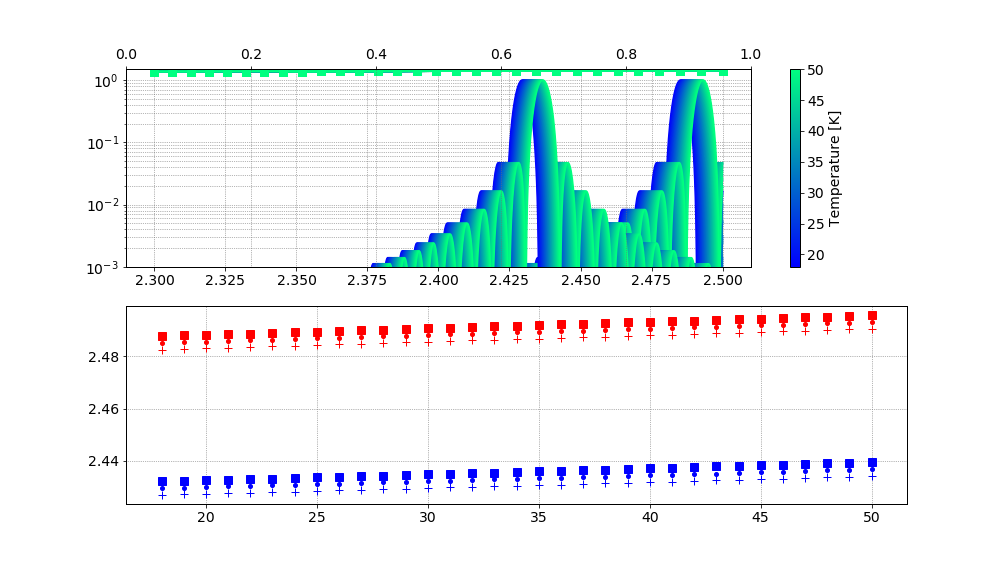

In [34]:
%matplotlib inline


Λ = np.reshape(λ_p,(len(λ_p),1,1)) / (neff_p_r - neff_s_r)
Λ_fab = 1.41 * u.um
L_fab = 1.3*u.mm
λ_s_qpm = np.zeros((len(w),len(T_C))) * u.um
λ_s_qpm_fwhm_plus = np.zeros((len(w),len(T_C))) * u.um
λ_s_qpm_fwhm_minus = np.zeros((len(w),len(T_C))) * u.um
Δk = np.zeros((len(w),len(T_C)))
n_λ_interp = 1000
λ_s_interp = np.linspace(λ_s.min().m,λ_s.max().m,n_λ_interp)*u.um
λ_p_interp = λ_s_interp / 2.0
Δk = np.empty((n_λ_interp,nw,nT),dtype=float) / u.um
η_rel_SHG = np.empty((n_λ_interp,nw,len(T_C)),dtype=float)

for wind,ww in enumerate(w):   
    for Tind,TT in enumerate(T_C):    
        λ_s_qpm[wind,Tind] = np.interp(Λ_fab.m,Λ[::-1,wind,Tind].m,λ_s[::-1].m) * u.um
        neff_s_interp = np.interp(λ_s_interp.m,λ_s[::-1],neff_s_r[::-1,wind,Tind])
        neff_p_interp = np.interp(λ_p_interp.m,λ_p[::-1],neff_p_r[::-1,wind,Tind])
        Δk[:,wind,Tind] = (2 * np.pi / λ_p_interp * ( neff_p_interp - neff_s_interp ) - 2 * np.pi / Λ_fab).to(1/u.um)        
        η_sinc_input = (Δk[:,wind,Tind] * L_fab / 2.0 / np.pi).to(u.dimensionless).m # differs from Marty's notes, ΔkL/(2π) instead of ΔkL/2 due to numpy definition of sinc 
        η_rel_SHG[:,wind,Tind] = np.sinc( η_sinc_input )**2
        λ_s_qpm_fwhm_plus[wind,Tind] = np.interp(0.5,η_rel_SHG[:,wind,Tind][(η_sinc_input>0.)*(η_sinc_input<2.)],λ_s_interp[(η_sinc_input>0.)*(η_sinc_input<2.)]) * u.um
        λ_s_qpm_fwhm_minus[wind,Tind] = np.interp(0.5,η_rel_SHG[:,wind,Tind][(η_sinc_input<0.)*(η_sinc_input>-2.)][::-1],λ_s_interp[(η_sinc_input<0.)*(η_sinc_input>-2.)][::-1]) * u.um
    
fig,ax = plt.subplots(2,1,figsize=(14,8))
ax0t = ax[0].twiny()

cmap = cm.winter
norm = Normalize(T_C.min().m,T_C.max().m)
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...


for wind,ww in enumerate(w): 
    for Tind,TT in enumerate(T_C):
        δneff_p = neff_p_r[:,wind,Tind] - neff_p_r[:,wind,0]
        δneff_s = neff_s_r[:,wind,Tind] - neff_s_r[:,wind,0]
#         ax[0].plot(λ_p,δneff_p,color=cmap(norm(TT.m)))
#         ax[0].plot(λ_s,neff_s_r[:,wind,Tind],'.-',color=cmap(norm(TT.m)))
#         ax[0].plot(λ_s,neff_p_r[:,wind,Tind],'^-',color=cmap(norm(TT.m)))
        ax[0].plot(λ_s,Λ[:,wind,Tind],'s-',color=cmap(norm(TT.m)))
        ax[0].semilogy(λ_s_interp,η_rel_SHG[:,wind,Tind],'-',color=cmap(norm(TT.m)))
    ax[1].plot(T_C,λ_s_qpm[wind,:],'.',color=colors[wind])
    ax[1].plot(T_C,λ_s_qpm_fwhm_plus[wind,:],'+',color=colors[wind])
    ax[1].plot(T_C,λ_s_qpm_fwhm_minus[wind,:],'s',color=colors[wind])
cbar = plt.colorbar(sm,ax=ax[0])
cbar.set_label('Temperature [K]')
ax[0].set_ylim([1e-3,1.5])

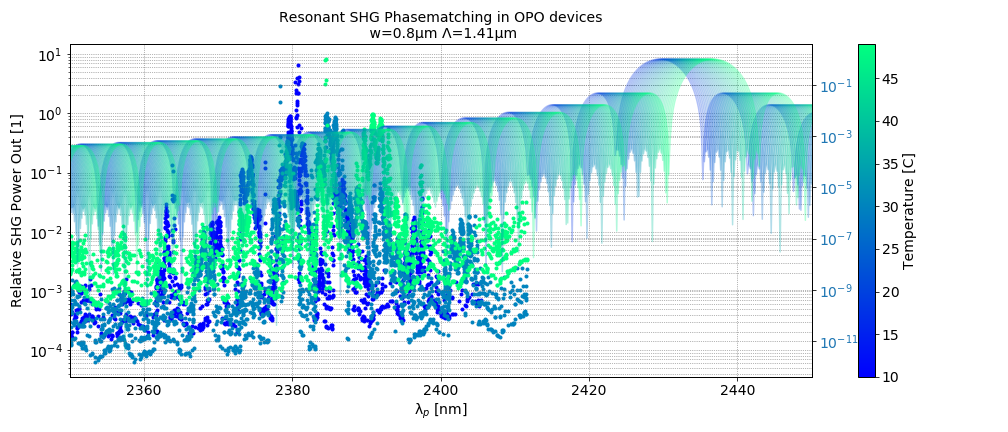

In [70]:
# Plot as requsted by Mircea (4/5/19) comparing an SHG broadband experimental curve (Dodd) with Lumerical sweeps

# load broadband SHG data. All were done with Vrb=9V
T = np.array([10,20,30,40,49]) 
ds = {}
for Tind,TT in enumerate(T):
    ds[f'{TT}'] = load_SHG_V_wavelength_sweep(name=f'V_rb_sweep2_{TT}C')

%matplotlib inline

T = np.array([10,20,30,40,49]) 
scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]
#η_SHG_peak = np.array
T = T[::2]
scale = scale[::2]
Λ_fit = 1.41 * u.um
δneff_s = [0.008,0]
λ_env = np.linspace(2340,2430,500)*u.nm

fig,ax=plt.subplots(1,1,figsize=(14,6))
cmap = cm.winter


# colormap for plotting
norm = Normalize(T.min(),T.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('Temperature [C]')
ax.set_xlabel('λ$_p$ [nm]')
ax.set_ylabel('Relative SHG Power Out [1]')
ax.set_title('Resonant SHG Phasematching in OPO devices\n w=0.8μm Λ=1.41μm')


for Tind,TT in enumerate(T):
    V_R = ds[f'{TT}']['V_R'][:,0,0]
    V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
    y = V_R[np.nonzero(V_R)]/V_P_24_ref_rel[np.nonzero(V_R)]**2 / scale[Tind]
    x = ds[f'{TT}']['lm_meas'][:,0,0][np.nonzero(V_R)]
#   η_SHG_env = η_SHG_fit(λ_env,δneff_s[Tind],T_U=TT,L_U=L_U_fab,Λ=Λ_fit)
    ax.semilogy(x,y,'o',markersize=3,color=cmap(norm(TT)))
#   ax.semilogy(λ_env,η_SHG_env,lw=2,color='k')

ax2 = ax.twinx()
color = 'tab:blue'
T_C = Q_(np.arange(18,51,1),u.degC)
for Tind,TT in enumerate(T_C):
    δneff_p = neff_p_r[:,wind,Tind] - neff_p_r[:,wind,0]
    δneff_s = neff_s_r[:,wind,Tind] - neff_s_r[:,wind,0]
#       ax2.plot(λ_p,δneff_p,color=cmap(norm(TT.m)))
#       ax2.plot(λ_s,neff_s_r[:,wind,Tind],'.-',color=cmap(norm(TT.m)))
#       ax2.plot(λ_s,neff_p_r[:,wind,Tind],'^-',color=cmap(norm(TT.m)))
#     ax2.plot(λ_s,Λ[:,wind,Tind],'s-',color=cmap(norm(TT.m)))
    ax2.semilogy(1000*λ_s_interp,η_rel_SHG[:,wind,Tind],'-',color=cmap(norm(TT.m)),alpha=0.3)

ax2.tick_params(axis='y', labelcolor=color)
# ax.set_ylim([3e-3,10])
ax.set_xlim([2350,2450])
#ax.set_ylim([1e-14,2e-10])
# ax2.set_xlim([2300,2500])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

NameError: name 'ds' is not defined

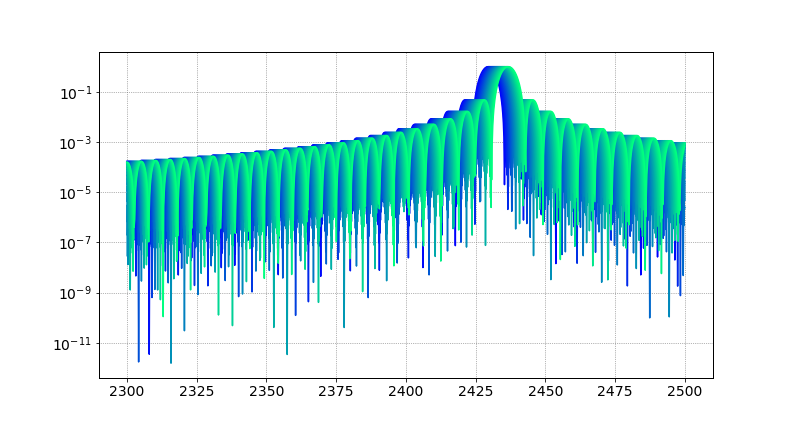

In [10]:
%matplotlib inline



fig,ax = plt.subplots(1,1,figsize=(11,6))
#ax0t = ax[0].twiny()

cmap = cm.winter
norm = Normalize(T_C.min().m,T_C.max().m)
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...


wind=1
for Tind,TT in enumerate(T_C):
#     δneff_p = neff_p_r[:,wind,Tind] - neff_p_r[:,wind,0]
#     δneff_s = neff_s_r[:,wind,Tind] - neff_s_r[:,wind,0]
#    ax[0].plot(λ_p,δneff_p,color=cmap(norm(TT.m)))
    #ax[0].plot(λ_s,neff_s_r[:,wind,Tind],'.-',color=cmap(norm(TT.m)))
    #ax[0].plot(λ_s,neff_p_r[:,wind,Tind],'^-',color=cmap(norm(TT.m)))
    #ax[0].plot(λ_s,Λ[:,wind,Tind],'s-',color=cmap(norm(TT.m)))
    ax.semilogy(λ_s_interp.to(u.nm),η_rel_SHG[:,wind,Tind],'-',color=cmap(norm(TT.m)))
    
for Tind,TT in enumerate(T):
    V_R = ds[f'{TT}']['V_R'][:,0,0]
    V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
    y = V_R[np.nonzero(V_R)]/V_P_24_ref_rel[np.nonzero(V_R)]**2 / scale[Tind]
    x = ds[f'{TT}']['lm_meas'][:,0,0][np.nonzero(V_R)]
#     η_SHG_env = η_SHG_fit(λ_env,δneff_s[Tind],T_U=TT,L_U=L_U_fab,Λ=Λ_fit)
    ax.semilogy(x,y,'o',markersize=3,color=cmap(norm(TT)))    

ax.plot(3000,0.1,'k-',label='model')
ax.plot(3000,0.1,'ko',markersize=3,label='experiment')


# ax[1].fill_between(T_C,λ_s_qpm_fwhm_plus[wind,:],λ_s_qpm_fwhm_minus[wind,:],color='C0',alpha=0.3)
# ax[1].plot(T_C,λ_s_qpm[wind,:],'.',color=colors[wind])
# ax[1].plot(T_C,λ_s_qpm_fwhm_plus[wind,:],'+',color=colors[wind])
# ax[1].plot(T_C,λ_s_qpm_fwhm_minus[wind,:],'s',color=colors[wind])
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('Temperature [K]')
ax.set_xlim([2350,2475])
ax.set_ylim([1e-3,1.5])
ax.legend()
ax.set_ylabel('relative SHG efficiency (1)')
ax.set_xlabel('fundamental wavelength (nm)')

## V2 WB1 Ch1 left OPO

In [26]:
# load broadband SHG data. name is stupid, all were done with Vrb=9V
T = np.array([10,20,30,40,49]) 
ds = {}
for Tind,TT in enumerate(T):
    ds[f'{TT}'] = load_SHG_V_wavelength_sweep(name=f'V_rb_sweep2_{TT}C')

(2360, 2408)

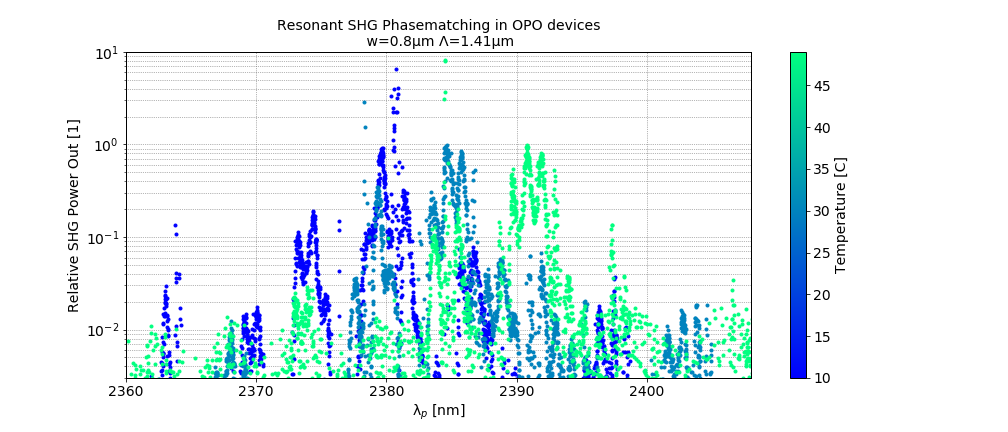

In [27]:
%matplotlib inline

T = np.array([10,20,30,40,49]) 
scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]
#η_SHG_peak = np.array
T = T[::2]
scale = scale[::2]
Λ_fit = 1.41 * u.um
δneff_s = [0.008,0]
λ_env = np.linspace(2340,2430,500)*u.nm

fig,ax=plt.subplots(1,1,figsize=(14,6))
cmap = cm.winter



# colormap for plotting
norm = Normalize(T.min(),T.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('Temperature [C]')
ax.set_xlabel('λ$_p$ [nm]')
ax.set_ylabel('Relative SHG Power Out [1]')
ax.set_title('Resonant SHG Phasematching in OPO devices\n w=0.8μm Λ=1.41μm')


for Tind,TT in enumerate(T):
    V_R = ds[f'{TT}']['V_R'][:,0,0]
    V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
    y = V_R[np.nonzero(V_R)]/V_P_24_ref_rel[np.nonzero(V_R)]**2 / scale[Tind]
    x = ds[f'{TT}']['lm_meas'][:,0,0][np.nonzero(V_R)]
#     η_SHG_env = η_SHG_fit(λ_env,δneff_s[Tind],T_U=TT,L_U=L_U_fab,Λ=Λ_fit)
    ax.semilogy(x,y,'o',markersize=3,color=cmap(norm(TT)))
#     ax.semilogy(λ_env,η_SHG_env,lw=2,color='k')

#ax.set_ylim([1e-14,2e-10])
ax.set_ylim([3e-3,10])
ax.set_xlim([2360,2408])

(2372, 2399)

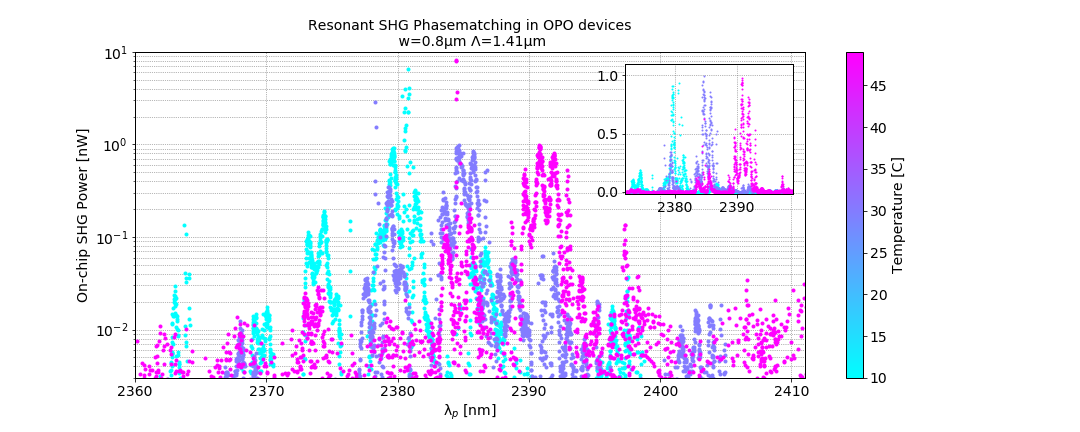

In [51]:
%matplotlib inline

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

T = np.array([10,20,30,40,49]) 
scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]
#η_SHG_peak = np.array
T = T[::2]
scale = scale[::2]
Λ_fit = 1.41 * u.um
δneff_s = [0.008,0]
λ_env = np.linspace(2340,2430,500)*u.nm

fig,ax=plt.subplots(1,1,figsize=(15,6))
cmap = cm.cool #cm.winter



# colormap for plotting
norm = Normalize(T.min(),T.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('Temperature [C]')
ax.set_xlabel('λ$_p$ [nm]')
ax.set_ylabel('On-chip SHG Power [nW]')
ax.set_title('Resonant SHG Phasematching in OPO devices\n w=0.8μm Λ=1.41μm')

axins = inset_axes(ax, width="25%", height="40%",borderpad=1)



for Tind,TT in enumerate(T):
    V_R = ds[f'{TT}']['V_R'][:,0,0]
    V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
    y = V_R[np.nonzero(V_R)]/V_P_24_ref_rel[np.nonzero(V_R)]**2 / scale[Tind]
    x = ds[f'{TT}']['lm_meas'][:,0,0][np.nonzero(V_R)]
#     η_SHG_env = η_SHG_fit(λ_env,δneff_s[Tind],T_U=TT,L_U=L_U_fab,Λ=Λ_fit)
    ax.semilogy(x,y,'o',markersize=3,color=cmap(norm(TT)))
    axins.plot(x,y,'o',markersize=1,color=cmap(norm(TT)))
#     ax.semilogy(λ_env,η_SHG_env,lw=2,color='k')

#ax.set_ylim([1e-14,2e-10])
ax.set_ylim([3e-3,10])
ax.set_xlim([2360,2411])
axins.set_ylim([-0.02,1.1])
axins.set_xlim([2372,2399])



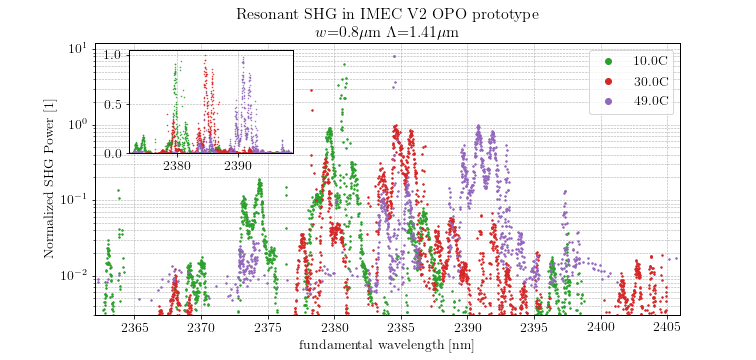

In [163]:
# plotting for thesis figure
import matplotlib
my_default_plot_params = {'savefig.dpi': 75,
                    'figure.autolayout': False,
                    'figure.figsize': (10, 6),
                    'font.family': 'Times New Roman', # "serif",
                    'font.size': 14,
                    'xtick.labelsize': 14,
                    'ytick.labelsize': 14,
                    'axes.labelsize': 14,
                    'axes.titlesize': 16,
                    'legend.fontsize': 14,
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'lines.linewidth': 1.0,
                    'axes.linewidth': 1.0,
                    'grid.linewidth':0.6,
                    'lines.markersize': 8,
                    'legend.markerscale': 2,
                    'text.usetex': True,
                    #'font.serif': "cm",
                    "grid.color": '0.7',
                    'grid.linestyle':'--',
                    'axes.grid': True,
                    'axes.grid.axis': 'both',
                    'axes.grid.which': 'both',
                    'image.cmap':'parula',}
#plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"
plt.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update(my_default_plot_params)


%matplotlib inline

# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# colors = ['r', 'b', 'g', 'm', 'c', 'k', 'orange', 'purple']

colors = [f'C{j}' for j in range(10)]

T = np.array([10,20,30,40,49]) 
scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]
#scale = [1 for j in range(len(T))]
#η_SHG_peak = np.array
T = T[::2]
scale = scale[::2]
Λ_fit = 1.41 * u.um
δneff_s = [0.008,0]
λ_env = np.linspace(2340,2430,500)*u.nm

fig,ax=plt.subplots(1,1,figsize=(10.5,5))
cmap = cm.cool #cm.winter



# # colormap for plotting
# norm = Normalize(T.min(),T.max())
# sm = cm.ScalarMappable(norm, cmap)
# sm.set_array([]) # You have to set a dummy-array for this to work...

# cbar = plt.colorbar(sm,ax=ax)
# cbar.set_label('Temperature [C]')
ax.set_xlabel('fundamental wavelength [nm]')
ax.set_ylabel('Normalized SHG Power [1]')
ax.set_title('Resonant SHG in IMEC V2 OPO prototype\n $w$=0.8$\mu$m $\Lambda$=1.41$\mu$m')
axins = inset_axes(ax, width="100%", height="100%",
                    bbox_to_anchor=(.07,0.62, .28, .38),
                    bbox_transform=ax.transAxes)



for Tind,TT in enumerate(T):
    y_raw = ds[f'{TT}']['V_R'][:,0,0]
    y_mask = y_raw.m >2e-14
    V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
    y = y_raw[y_mask]/V_P_24_ref_rel[y_mask]**2 / scale[Tind]
    #y = y_raw[y_mask] / scale[Tind]
    x = ds[f'{TT}']['lm_meas'][:,0,0][y_mask]
    y = y[np.argsort(x)]
    x.sort()
#     η_SHG_env = η_SHG_fit(λ_env,δneff_s[Tind],T_U=TT,L_U=L_U_fab,Λ=Λ_fit)
    ax.semilogy(x,y,'.',markersize=3,color=colors[Tind+2],label=f'{TT:3.1f}C')
    axins.plot(x,y,'.',markersize=1,color=colors[Tind+2],label=f'{TT:3.1f}C')
#     ax.semilogy(λ_env,η_SHG_env,lw=2,color='k')

ax.legend(loc='upper right',markerscale=4)
#ax.set_ylim([1e-14,2e-10])
ax.set_ylim([3e-3,12])
ax.set_xlim([2362,2406])
axins.set_ylim([0.0,1.05])
#axins.set_ylim([-0.2,9])
axins.set_xlim([2372,2399])


fig_dir ='/home/dodd/github/thesis/si_chi2_expt/figs'
fname = 'imec_v2_resonant_shg_v0.pdf'
save_fig = True
if save_fig:
    plt.savefig(path.join(fig_dir,fname),
                dpi=75, 
                facecolor='w',
                edgecolor='w',
                orientation='portrait', 
                transparent=False, 
                bbox_inches='tight', 
                pad_inches=0.1,
                frameon=None)

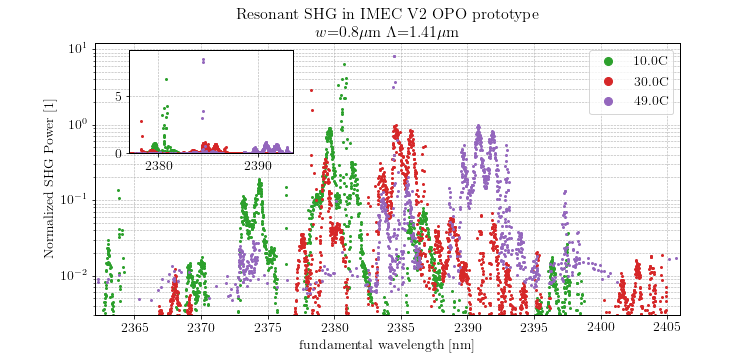

In [168]:
# plotting for thesis figure
import matplotlib
my_default_plot_params = {'savefig.dpi': 75,
                    'figure.autolayout': False,
                    'figure.figsize': (10, 6),
                    'font.family': 'Times New Roman', # "serif",
                    'font.size': 14,
                    'xtick.labelsize': 14,
                    'ytick.labelsize': 14,
                    'axes.labelsize': 14,
                    'axes.titlesize': 16,
                    'legend.fontsize': 14,
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'lines.linewidth': 1.0,
                    'axes.linewidth': 1.0,
                    'grid.linewidth':0.6,
                    'lines.markersize': 8,
                    'legend.markerscale': 2,
                    'text.usetex': True,
                    #'font.serif': "cm",
                    "grid.color": '0.7',
                    'grid.linestyle':'--',
                    'axes.grid': True,
                    'axes.grid.axis': 'both',
                    'axes.grid.which': 'both',
                    'image.cmap':'parula',}
#plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"
plt.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update(my_default_plot_params)


%matplotlib inline

# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# colors = ['r', 'b', 'g', 'm', 'c', 'k', 'orange', 'purple']

colors = [f'C{j}' for j in range(10)]

T = np.array([10,20,30,40,49]) 
scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]
#scale = [1 for j in range(len(T))]
#η_SHG_peak = np.array
T = T[::2]
scale = scale[::2]
Λ_fit = 1.41 * u.um
δneff_s = [0.008,0]
λ_env = np.linspace(2340,2430,500)*u.nm

fig,ax=plt.subplots(1,1,figsize=(10.5,5))
cmap = cm.cool #cm.winter



# # colormap for plotting
# norm = Normalize(T.min(),T.max())
# sm = cm.ScalarMappable(norm, cmap)
# sm.set_array([]) # You have to set a dummy-array for this to work...

# cbar = plt.colorbar(sm,ax=ax)
# cbar.set_label('Temperature [C]')
ax.set_xlabel('fundamental wavelength [nm]')
ax.set_ylabel('Normalized SHG Power [1]')
ax.set_title('Resonant SHG in IMEC V2 OPO prototype\n $w$=0.8$\mu$m $\Lambda$=1.41$\mu$m')
axins = inset_axes(ax, width="100%", height="100%",
                    bbox_to_anchor=(.07,0.62, .28, .38),
                    bbox_transform=ax.transAxes)



for Tind,TT in enumerate(T):
    y_raw = ds[f'{TT}']['V_R'][:,0,0]
    y_mask = y_raw.m >2e-14
    V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
    y = y_raw[y_mask]/V_P_24_ref_rel[y_mask]**2 / scale[Tind]
    #y = y_raw[y_mask] / scale[Tind]
    x = ds[f'{TT}']['lm_meas'][:,0,0][y_mask]
    y = y[np.argsort(x)]
    x.sort()
#     η_SHG_env = η_SHG_fit(λ_env,δneff_s[Tind],T_U=TT,L_U=L_U_fab,Λ=Λ_fit)
    ax.semilogy(x,y,'.',markersize=4,color=colors[Tind+2],label=f'{TT:3.1f}C')
    axins.plot(x,y,'.',markersize=4,color=colors[Tind+2],label=f'{TT:3.1f}C')
#     ax.semilogy(λ_env,η_SHG_env,lw=2,color='k')

ax.legend(loc='upper right',markerscale=4)
#ax.set_ylim([1e-14,2e-10])
ax.set_ylim([3e-3,12])
ax.set_xlim([2362,2406])
axins.set_ylim([0.0,9])
#axins.set_ylim([-0.2,9])
axins.set_xlim([2377,2393.5])


fig_dir ='/home/dodd/github/thesis/si_chi2_expt/figs'
fname = 'imec_v2_resonant_shg_v1.pdf'
save_fig = True
if save_fig:
    plt.savefig(path.join(fig_dir,fname),
                dpi=75, 
                facecolor='w',
                edgecolor='w',
                orientation='portrait', 
                transparent=False, 
                bbox_inches='tight', 
                pad_inches=0.1,
                frameon=None)

(-0.05, 1.05)

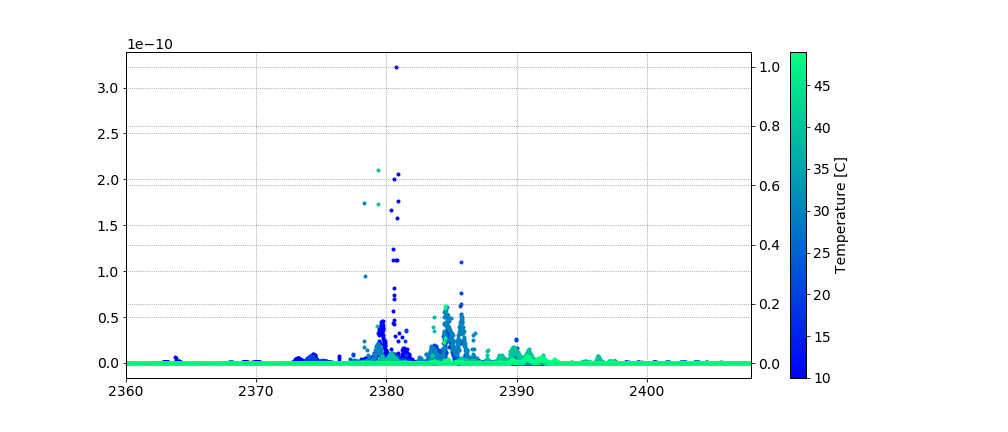

In [29]:
%matplotlib inline

T = np.array([10,20,30,40,49]) 
scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]


#η_SHG_peak = np.array


# T = T[::2]
scale = np.ones(len(T))
# scale = scale[::2]

fig,ax=plt.subplots(1,1,figsize=(14,6))
ax2 = ax.twinx()
cmap = cm.winter



# colormap for plotting
norm = Normalize(T.min(),T.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('Temperature [C]')

for Tind,TT in enumerate(T):
    V_R = ds[f'{TT}']['V_R'][:,0,0]
    V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
    y = V_R[np.nonzero(V_R)]/V_P_24_ref_rel[np.nonzero(V_R)]**2 / scale[Tind]
    y2 = V_P_24_ref_rel[np.nonzero(V_R)]**2
    x = ds[f'{TT}']['lm_meas'][:,0,0][np.nonzero(V_R)]
    ax.plot(x,y,'o',markersize=3,color=cmap(norm(TT)))
    #ax2.plot(x,y2,'--',lw=1,color=cmap(norm(TT)))
    

#ax.set_ylim([1e-14,2e-10])
#ax.set_ylim([-0.05,1.05])
ax.set_xlim([2360,2408])
ax2.set_ylim([-0.05,1.05])




(2369, 2393)

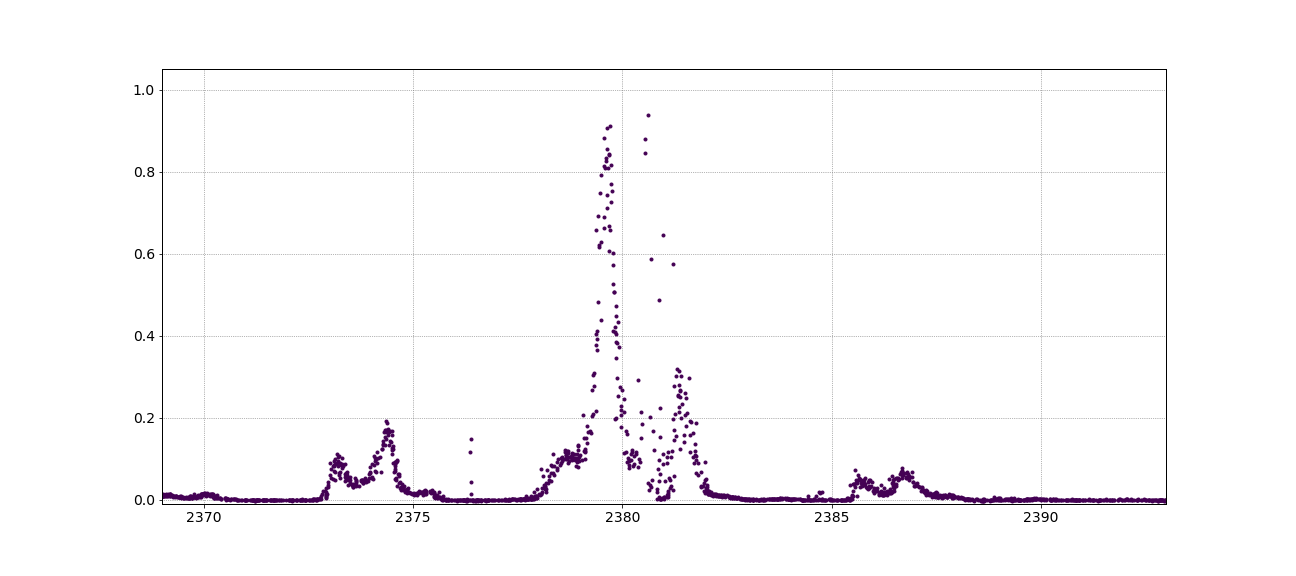

In [42]:
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(18,8))
cmap = cm.viridis

scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]

# colormap for plotting
norm = Normalize(T.min(),T.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

# cbar = plt.colorbar(sm,ax=ax)
# cbar.set_label('Temperature [C]')

Tind = 0
TT = 10
V_R = ds[f'{TT}']['V_R'][:,0,0]
V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
y = V_R[np.nonzero(V_R)]/V_P_24_ref_rel[np.nonzero(V_R)]**2 / scale[Tind]
x = ds[f'{TT}']['lm_meas'][:,0,0][np.nonzero(V_R)]
ax.plot(x,y,'o',markersize=3,color=cmap(norm(TT)))

#ax.set_ylim([1e-14,2e-10])
ax.set_ylim([-.01,1.05])
ax.set_xlim([2369,2393])


(2379, 2402)

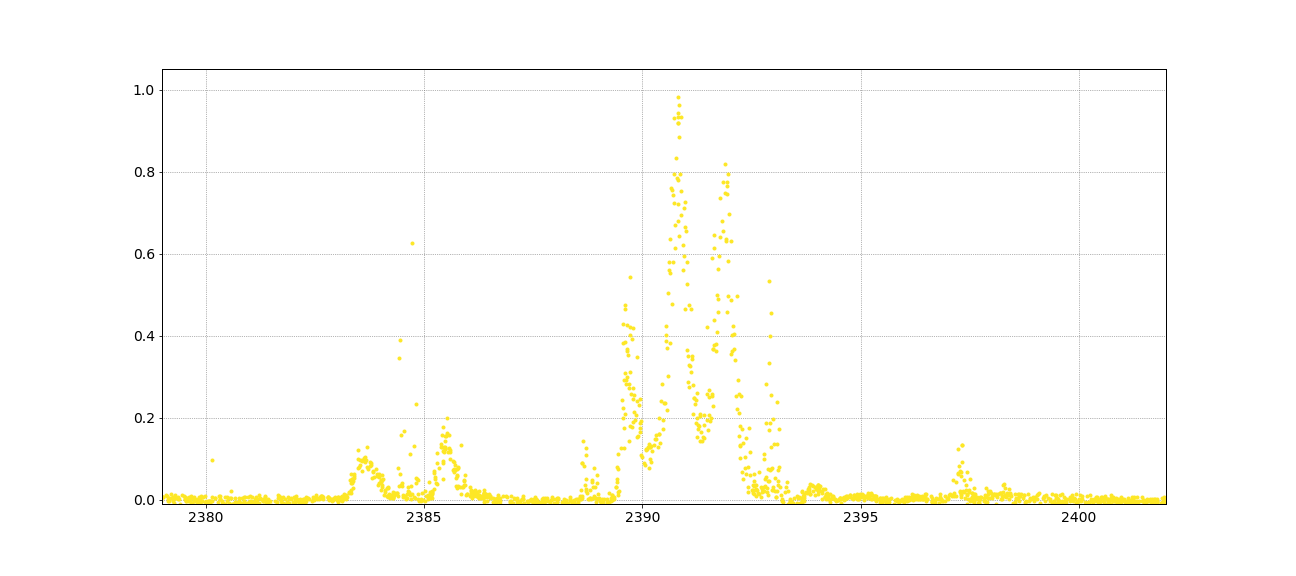

In [41]:
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(18,8))
cmap = cm.viridis

scale = [5e-11,4.5e-11,6.1e-11,2.5e-11,7.5e-12]

# colormap for plotting
norm = Normalize(T.min(),T.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

# cbar = plt.colorbar(sm,ax=ax)
# cbar.set_label('Temperature [C]')

Tind = 4
TT = 49
V_R = ds[f'{TT}']['V_R'][:,0,0]
V_P_24_ref_rel = ds[f'{TT}']['V_P_24_ref'][:,0,0] / ds[f'{TT}']['V_P_24_ref'][:,0,0].max()
y = V_R[np.nonzero(V_R)]/V_P_24_ref_rel[np.nonzero(V_R)]**2 / scale[Tind]
x = ds[f'{TT}']['lm_meas'][:,0,0][np.nonzero(V_R)]
ax.plot(x,y,'o',markersize=3,color=cmap(norm(TT)))

#ax.set_ylim([1e-14,2e-10])
ax.set_ylim([-.01,1.05])
ax.set_xlim([2379,2402])


## Comparison with experiment SHG data

In [ ]:
# import experiment SHG data from IMEC V2, w = 800nm, g = 400nm device (WB1,CH4)

# Tsweep 1 (upconversion detector QPM)

## import data

In [10]:
#Import lumerical T-dependent waveguide dispersion data

# code from sweep script (.lsf) for reference
### Set up sweep
# HH = 215e-9; # core height
# hh = 60e-9; # cladding height
# nw = 2;
# w = linspace(0.78e-6,0.8e-6,nw);
# #h_list = [0, 60e-9,100e-9,150e-9];
# #nh = length(h_list);
# #H_list = [215e-9];
# #nH = length(H_list);
# T_list_C = linspace(18,50,50-18+1);
# T_list_K = linspace(273.15+18,273.15+50,50-18+1);
# nT = length(T_list_K);

# lm_stop = 1.15e-6; # pump wavelength sweep start
# lm_start = 1.25e-6; # pump wavelength sweep stop
# n_lm = 30;

n_sweep = 0

λ_p_stop = 1.15 *u.um # [um] pump wavelength sweep start
λ_p_start = 2.0 *u.um # [um] pump wavelength sweep stop

λ_s_stop = 2*λ_p_stop # [um] signal wavelength sweep start
λ_s_start = 2*λ_p_start # [um] signal wavelength sweep stop

f_p_stop = ( u.speed_of_light / λ_p_stop ).to(u.THz)
f_p_start = ( u.speed_of_light / λ_p_start ).to(u.THz)
nλ = 80
nw = 2
nT = 50-18+1 # one simulation per integer temperature in Celsius, 18-50C
f_p = np.linspace(f_p_start.m,f_p_stop.m,nλ)*u.THz
f_s = f_p / 2
λ_p = ( u.speed_of_light / ( f_p ) ).to(u.um)
λ_s = ( u.speed_of_light / ( f_s ) ).to(u.um)
w = np.array([0.78,0.8]) * u.um # np.array([0.78,0.8]) * u.um
h = 60*u.nm
H = 215*u.nm
T_C = Q_(np.arange(18,51,1),u.degC)
T_K = T_C.to(u.degK)
#wdope = np.linspace(-50,150,nwdope) * u.nm

data_dir = f"C:/Users/Lab/Google Drive/notebooks/IMEC_chi2_wg_experiments/lumerical/sweep1_UC_det"
#data_dir = "/Users/doddgray/Google Drive/notebooks/IMEC_chi2_wg_experiments/lumerical/sweep1_UC_det"

f_p_load = np.empty((nλ,nT),dtype=float) * u.THz  # ( f['f_p'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
f_s_load = np.empty((nλ,nT),dtype=float) * u.THz # ( f['f_s'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
lm_p_load = np.empty((nλ,nT),dtype=float) * u.cm # ( f['lm_p'].value.view(np.float).squeeze() * u.m ).to(u.um)
lm_s_load = np.empty((nλ,nT),dtype=float) * u.cm # ( f['lm_s'].value.view(np.float).squeeze() * u.m ).to(u.um)
neff_p_r = np.empty((nλ,nT),dtype=float) # f['neff_p_r'].value.view(np.float).squeeze()
neff_p_i = np.empty((nλ,nT),dtype=float) # f['neff_p_i'].value.view(np.float).squeeze()
neff_s_r = np.empty((nλ,nT),dtype=float) # f['neff_s_r'].value.view(np.float).squeeze()
neff_s_i = np.empty((nλ,nT),dtype=float) # f['neff_s_i'].value.view(np.float).squeeze()
ng_p = np.empty((nλ,nT),dtype=float) # f['ng_p'].value.view(np.float).squeeze()
ng_s = np.empty((nλ,nT),dtype=float) # f['ng_s'].value.view(np.float).squeeze()



for Tind, TT in enumerate(T_C):
    fname = f'w12_T{Tind+1}_mode.mat'
    fpath = path.normpath(path.join(data_dir,fname))
    f = h5py.File(fpath,'r')
    #f.keys()
    if Tind==0:
        f_p_load = ( f['f_p'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
        f_s_load = ( f['f_s'].value.view(np.float).squeeze() * u.Hz ).to(u.THz)
        lm_p_load = ( f['lm_p'].value.view(np.float).squeeze() * u.m ).to(u.um)
        lm_s_load = ( f['lm_s'].value.view(np.float).squeeze() * u.m ).to(u.um)
    neff_p_r[:,Tind] = f['neff_p_r'].value.view(np.float).squeeze()
    neff_p_i[:,Tind] = f['neff_p_i'].value.view(np.float).squeeze()
    neff_s_r[:,Tind] = f['neff_s_r'].value.view(np.float).squeeze()
    neff_s_i[:,Tind] = f['neff_s_i'].value.view(np.float).squeeze()
    ng_p[:,Tind] = f['ng_p'].value.view(np.float).squeeze()
    ng_s[:,Tind] = f['ng_s'].value.view(np.float).squeeze()
    f.close()

In [11]:
# create 2D interpolated model of effective index as a function of wavelength and temperature

# 1200nm wide ridge

y_s = λ_s[::-1].m
x = T_C.m
z_s = neff_s_r[::-1,:]
f_neff_s_interp = interp2d(x,y_s,z_s) # this function takes T[C],λ_s[um] as inputs and returns an interpolated effective index
y_p = λ_p[::-1].m
z_p = neff_p_r[::-1,:]
f_neff_p_interp = interp2d(x,y_p,z_p) # this function takes T[C],λ_p[um] as inputs and returns an interpolated effective index

# define function to get the power in the U as a function of λ[um], T_U[C], T_ring[C] and cavity geometry parameters
def get_P_U_with_loss(λ,T_U,T_ring, L_U, L_ring, alpha_half_ring, alpha_u, kappa_1, kappa_2, E0=1):
    t1 = sqrt(1.-kappa_1**2)
    t2 = sqrt(1.-kappa_2**2)
    c1 = 1.j*kappa_1
    c2 = 1.j*kappa_2
    N_λ = len(λ)
    N_T_U = len(T_U)
    N_T_ring = len(T_ring)
    n_ring = f_neff_s_interp(T_ring.m,λ.to(u.um).m)[:,:,newaxis] * np.ones(N_T_U)
    n_u = np.swapaxes(f_neff_s_interp(T_U.m,λ.to(u.um).m)[:,:,newaxis] * np.ones(N_T_ring),1,2)
    k = 2*np.pi / ( λ[:, newaxis, newaxis]*ones((N_T_ring, N_T_U)) ) 
    numerator = c1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k)+c2*t1*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    z = t1*t2*(1.-alpha_half_ring)**2*exp(1.j*n_ring*L_ring*k) + c1*c2*(1.-alpha_u)*(1.-alpha_half_ring)*exp(1.j*(n_u*L_U+n_ring*L_ring/2.)*k)
    denominator = 1. - z
    E_ring_2 = numerator/denominator*E0
    E_ring_1 = (1.-alpha_half_ring)*exp(1.j*n_ring*L_ring/2.*k)*(c1*E0 + t1*E_ring_2)
    E_cavity = t1*E0 + c1*E_ring_2
    E_out = c2*E_ring_1 + t2*(1.-alpha_u)*E_cavity*exp(1.j*n_u*L_U*k)
#     P_ring_2 = abs(E_ring_2)**2
#     P_ring_1 = abs(E_ring_1)**2
    P_cavity = abs(E_cavity)**2
    P_out = abs(E_out)**2
    return P_cavity, P_out

# default geometry parameters based on intended fab design:
Λ_fab = 1.41*u.um
L_U_straight = 583 * u.um
d_U_curve = 122.35*u.um
L_U_curve = np.pi * d_U_curve / 2.0
L_U_fab = 2 * L_U_straight + L_U_curve
d_ring = 120*u.um
L_ring_fab = np.pi * d_ring

# define function to get relative SHG efficiency per squared input power as a function of λ[um], T_U[C] and cavity geometry parameters
def η_SHG_U(λ_s,T_U=20,L_U=L_U_fab,Λ=Λ_fab):
    λ_p = λ_s/2.0
    n_s = f_neff_s_interp(T_U,λ_s.to(u.um).m).squeeze()
    n_p = f_neff_p_interp(T_U,λ_p.to(u.um).m).squeeze()
    Δk = (2 * np.pi / λ_p * ( n_p - n_s ) - 2 * np.pi / Λ).to(1/u.um)        
    η_sinc_input = (Δk * L_U / 2.0 / np.pi).to(u.dimensionless).m # differs from Marty's notes, ΔkL/(2π) instead of ΔkL/2 due to numpy definition of sinc 
    η_rel_SHG = np.sinc( η_sinc_input )**2
    return η_rel_SHG         


def η_SHG_fit(λ_s,δneff_s,T_U=20,L_U=L_U_fab,Λ=Λ_fab):
    λ_p = λ_s/2.0
    n_s = f_neff_s_interp(T_U,λ_s.to(u.um).m).squeeze()+δneff_s
    n_p = f_neff_p_interp(T_U,λ_p.to(u.um).m).squeeze()
    Δk = (2 * np.pi / λ_p * ( n_p - n_s ) - 2 * np.pi / Λ).to(1/u.um)        
    η_sinc_input = (Δk * L_U / 2.0 / np.pi).to(u.dimensionless).m # differs from Marty's notes, ΔkL/(2π) instead of ΔkL/2 due to numpy definition of sinc 
    η_rel_SHG = np.sinc( η_sinc_input )**2
    return η_rel_SHG         
     


In [53]:
### define a function to find the quasi-phase-matched "signal" (lowest frequency) and SFG (highest frequency) wavelengths
### as a function of pump wavelength and chip temperature for our waveguide geometry and poling period


# # default geometry parameters based on intended fab design:
Λ_fab_UC = 1.77 * u.um
L_U_straight_0_UC = 197.66 * u.um
L_U_straight_1_UC = 391.47 * u.um
d_U_curve_UC = 122.76 * u.um
L_U_curve_UC = np.pi * d_U_curve_UC / 2.0
L_U_fab_UC = L_U_straight_0_UC + L_U_straight_1_UC + L_U_curve_UC
d_ring_UC = 120*u.um
L_ring_fab_UC = np.pi * d_ring_UC

print(L_U_fab_UC)

def UC_QPM(λ_p,T,λ_s_min=2.9*u.um,λ_s_max=3.6*u.um,n_λ_s=3000,Λ=Λ_fab_UC):
    λ_s = np.linspace(λ_s_min.m,λ_s_max.m,n_λ_s) * u.um
    neff_s = f_neff_s_interp(T,λ_s.to(u.um).m)
    neff_p = f_neff_s_interp(T,λ_p.to(u.um).m)
    λ_p_mg = λ_p[np.newaxis,np.newaxis,:]
    λ_s_mg = λ_s[:,np.newaxis,np.newaxis]
    λ_sfg = 1 / ( 1 / λ_p_mg + 1 / λ_s_mg )
    neff_s_mg = neff_s[:,:,np.newaxis]
    neff_p_mg = neff_p.T[np.newaxis,:,:]
    neff_sfg = np.zeros((len(λ_s),len(T),len(λ_p)))
    for λind,λ in enumerate(λ_p):
        neff_sfg[:,:,λind] = f_neff_p_interp(T,λ_sfg[:,0,λind].to(u.um).m)
    Δk = 2*np.pi * ( neff_sfg / λ_sfg - neff_p_mg / λ_p_mg - neff_s_mg / λ_s_mg - 1 / Λ )
    λ_s_qpm = λ_s[np.abs(Δk).argmin(axis=0)]
    return λ_s_qpm
    

781.9609570773415 micrometer


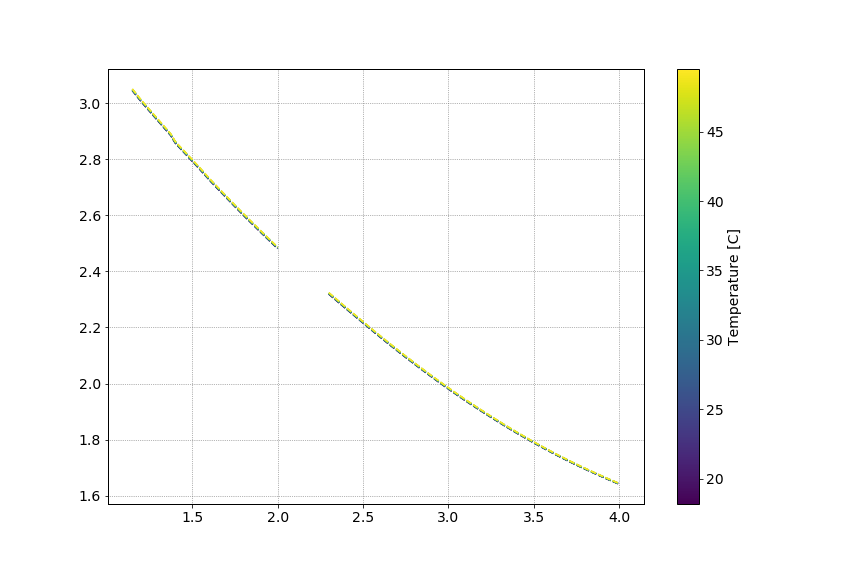

In [54]:
# plot index dispersion
%matplotlib inline
cmap = cm.viridis

λ_s_i = np.linspace(λ_s.min().m,λ_s.max().m,300) * u.um
λ_p_i = np.linspace(λ_p.min().m,λ_p.max().m,300) * u.um
# λ_s_i = np.linspace(1.0001*λ_s.min().m,0.9999*λ_s.max().m,300) * u.um
# λ_p_i = np.linspace(1.0001*λ_p.min().m,0.9999*λ_p.max().m,300) * u.um
T_i = np.linspace(1.01*T_C.m.min(),0.99*T_C.m.max(),10) 
neff_s_i = f_neff_s_interp(T_i,λ_s_i.to(u.um).m)
neff_p_i = f_neff_p_interp(T_i,λ_p_i.to(u.um).m)

fig,ax = plt.subplots(1,1,figsize=(12,8))
# colormap for plotting

norm = Normalize(T_i.min(),T_i.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('Temperature [C]')

for Tind,TT in enumerate(T_i):
    ax.plot(λ_p_i,neff_p_i[:,Tind],'--',color=cmap(norm(TT)))
    #ax.plot(λ_p,neff_p_r[:,Tind],'.',color=cmap(norm(TT)))
    ax.plot(λ_s_i,neff_s_i[:,Tind],'--',color=cmap(norm(TT)))
    #ax.plot(λ_s,neff_s_r[:,Tind],'.',color=cmap(norm(TT)))

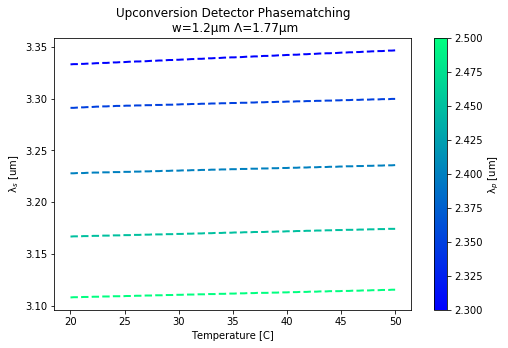

In [54]:
# plot quasi-phase matched signal wavelength as a function of pump wavelength and temperature
%matplotlib inline
cmap = cm.winter

λ_p = np.array([2.3,2.35,2.4,2.45,2.5])*u.um
T = np.linspace(20,50,100)
λ_s_qpm = UC_QPM(λ_p,T)
fig,ax = plt.subplots(1,1,figsize=(8,5))
# colormap for plotting

norm = Normalize(λ_p.min(),λ_p.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('λ$_p$ [um]')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('λ$_s$ [um]')
ax.set_title('Upconversion Detector Phasematching\n w=1.2μm Λ=1.77μm')

for λind,λ in enumerate(λ_p):
    ax.plot(T,λ_s_qpm[:,λind],'--',lw=2,color=cmap(norm(λ.m)))

781.9609570773415 micrometer


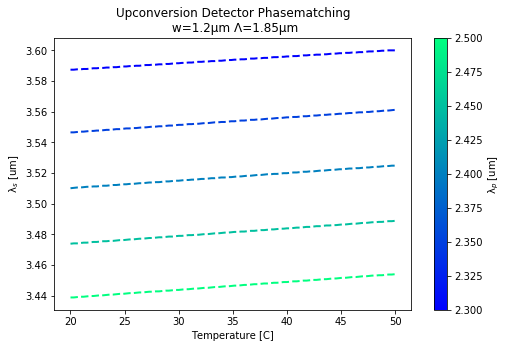

In [15]:
# tolerances 5f IMEC; how this changes the phase matching curves
Λ_fab_UC = 1.85 * u.um  #(+80nm off)
L_U_straight_0_UC = 197.66 * u.um
L_U_straight_1_UC = 391.47 * u.um
d_U_curve_UC = 122.76 * u.um
L_U_curve_UC = np.pi * d_U_curve_UC / 2.0
L_U_fab_UC = L_U_straight_0_UC + L_U_straight_1_UC + L_U_curve_UC
d_ring_UC = 120*u.um
L_ring_fab_UC = np.pi * d_ring_UC

print(L_U_fab_UC)

def UC_QPM(λ_p,T,λ_s_min=2.9*u.um,λ_s_max=3.6*u.um,n_λ_s=3000,Λ=Λ_fab_UC):
    λ_s = np.linspace(λ_s_min.m,λ_s_max.m,n_λ_s) * u.um
    neff_s = f_neff_s_interp(T,λ_s.to(u.um).m)
    neff_p = f_neff_s_interp(T,λ_p.to(u.um).m)
    λ_p_mg = λ_p[np.newaxis,np.newaxis,:]
    λ_s_mg = λ_s[:,np.newaxis,np.newaxis]
    λ_sfg = 1 / ( 1 / λ_p_mg + 1 / λ_s_mg )
    neff_s_mg = neff_s[:,:,np.newaxis]
    neff_p_mg = neff_p.T[np.newaxis,:,:]
    neff_sfg = np.zeros((len(λ_s),len(T),len(λ_p)))
    for λind,λ in enumerate(λ_p):
        neff_sfg[:,:,λind] = f_neff_p_interp(T,λ_sfg[:,0,λind].to(u.um).m)
    Δk = 2*np.pi * ( neff_sfg / λ_sfg - neff_p_mg / λ_p_mg - neff_s_mg / λ_s_mg - 1 / Λ )
    λ_s_qpm = λ_s[np.abs(Δk).argmin(axis=0)]
    return λ_s_qpm

# plot quasi-phase matched signal wavelength as a function of pump wavelength and temperature
%matplotlib inline
cmap = cm.winter

λ_p = np.array([2.3,2.35,2.4,2.45,2.5])*u.um
T = np.linspace(20,50,100)
λ_s_qpm = UC_QPM(λ_p,T)
fig,ax = plt.subplots(1,1,figsize=(8,5))
# colormap for plotting

norm = Normalize(λ_p.min(),λ_p.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('λ$_p$ [um]')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('λ$_s$ [um]')
ax.set_title('Upconversion Detector Phasematching\n w=1.2μm Λ=1.85μm')

for λind,λ in enumerate(λ_p):
    ax.plot(T,λ_s_qpm[:,λind],'--',lw=2,color=cmap(norm(λ.m)))

781.9609570773415 micrometer


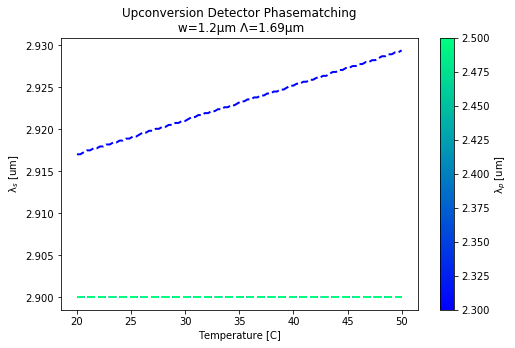

In [57]:
# tolerances of IMEC; how this changes the phase matching curves
Λ_fab_UC = 1.69 * u.um  #(-80nm off)
L_U_straight_0_UC = 197.66 * u.um
L_U_straight_1_UC = 391.47 * u.um
d_U_curve_UC = 122.76 * u.um
L_U_curve_UC = np.pi * d_U_curve_UC / 2.0
L_U_fab_UC = L_U_straight_0_UC + L_U_straight_1_UC + L_U_curve_UC
d_ring_UC = 120*u.um
L_ring_fab_UC = np.pi * d_ring_UC

print(L_U_fab_UC)

def UC_QPM(λ_p,T,λ_s_min=2.9*u.um,λ_s_max=3.6*u.um,n_λ_s=3000,Λ=Λ_fab_UC):
    λ_s = np.linspace(λ_s_min.m,λ_s_max.m,n_λ_s) * u.um
    neff_s = f_neff_s_interp(T,λ_s.to(u.um).m)
    neff_p = f_neff_s_interp(T,λ_p.to(u.um).m)
    λ_p_mg = λ_p[np.newaxis,np.newaxis,:]
    λ_s_mg = λ_s[:,np.newaxis,np.newaxis]
    λ_sfg = 1 / ( 1 / λ_p_mg + 1 / λ_s_mg )
    neff_s_mg = neff_s[:,:,np.newaxis]
    neff_p_mg = neff_p.T[np.newaxis,:,:]
    neff_sfg = np.zeros((len(λ_s),len(T),len(λ_p)))
    for λind,λ in enumerate(λ_p):
        neff_sfg[:,:,λind] = f_neff_p_interp(T,λ_sfg[:,0,λind].to(u.um).m)
    Δk = 2*np.pi * ( neff_sfg / λ_sfg - neff_p_mg / λ_p_mg - neff_s_mg / λ_s_mg - 1 / Λ )
    λ_s_qpm = λ_s[np.abs(Δk).argmin(axis=0)]
    return λ_s_qpm

# plot quasi-phase matched signal wavelength as a function of pump wavelength and temperature
%matplotlib inline
cmap = cm.winter

λ_p = np.array([2.3,2.35,2.4,2.45,2.5])*u.um
T = np.linspace(20,50,100)
λ_s_qpm = UC_QPM(λ_p,T)
fig,ax = plt.subplots(1,1,figsize=(8,5))
# colormap for plotting

norm = Normalize(λ_p.min(),λ_p.max())
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('λ$_p$ [um]')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('λ$_s$ [um]')
ax.set_title('Upconversion Detector Phasematching\n w=1.2μm Λ=1.69μm')

for λind,λ in enumerate(λ_p):
    ax.plot(T,λ_s_qpm[:,λind],'--',lw=2,color=cmap(norm(λ.m)))

# Expected OPA behavior from simulation

## By-hand values

In [18]:
#### taking values from si_opo_sims_note1.pdf for a pump near λ_p=1.193μm, signal near λ_s=2.385μm

# fabricated wg details
τ_c = 20 * u.ps # this is still a guess, could be <20ps
Λ = 1.41 * u.um
dc = (0.6*u.um / Λ).to(u.dimensionless).m
w = 800 * u.nm
wd = 100 * u.nm # 50nm on each side, 100nm total
ar = ( Λ / (wd+w) ).to(u.dimensionless).m
      
# free-space wavelengths
λ_s = 2.385*u.um
λ_p = λ_s/2.0
c = u.speed_of_light
f_s = (λ_s * c) * u.THz
f_p = (λ_p * c) * u.THz
ω_s = 2* np.pi * f_s 
ω_p= 2* np.pi * f_p

# linear material coefficients
n_si_p = 3.515
n_si_s = 3.44

# material limited cofficients for nonlinear model
κ = 0.9e-4/np.sqrt(1*u.watt)
β_xtpa = 0.8e-9 * u.cm / u.watt
γ = 1.7e-19 * u.cm**3 / u.watt**2 / u.ps
ζ = 3e-12 / u.watt / u.ps

# wg geometry dependent effective indices, losses and effective areas for nonlinear coupling 
neff_p = 2.96
neff_s = 2.12
ngeff_p = 3.95
ngeff_s = 3.58
alpha_tot_s_dB = 1.1 / u.cm 
# this appears to come dominantly from sidewall roughness scattering, 
# with another ~0.1dB/cm expected for 100% duty-cycle doping (we are at 42%)
O_113 = 0.34
O_13 = 0.27
O_33 = 0.28
O_1c = 0.14

Aeff_p = 0.14 * u.um**2
Aeff_s = 0.23 * u.um**2
Aeff_c = 0.04 * u.um**2

η_χ2 = 0.5#0.3 # this includes the 2/π factor,
# and then further reduces it to account for non-square-wave shape and lower breakdown voltage

κ_prime = 0.505 * κ * η_χ2
β_prime = 0.41 * β_xtpa
γ_prime = 0.32 * γ

P_p = np.logspace(-2,0,300) * u.watt
I_p = ( P_p / Aeff_p ).to(u.watt/u.cm**2)


OPA_term = (κ_prime * np.sqrt(I_p)).to(1/u.cm)
xTPA_term = (2 * β_prime * I_p).to(1/u.cm)
FCA_term = ( τ_c * ( γ_prime * I_p**2 ) )

OPA_term_dB = OPA_term * 10 / np.log(10)
xTPA_term_dB = xTPA_term * 10 / np.log(10)
FCA_term_dB = FCA_term * 10 / np.log(10)
linear_term_dB = alpha_tot_s_dB

g_net_dB = OPA_term_dB - xTPA_term_dB - FCA_term_dB - linear_term_dB

print(f'dc: {dc:3.3f}')
print(f'ar: {ar:3.3f}')

dc: 0.426
ar: 1.567


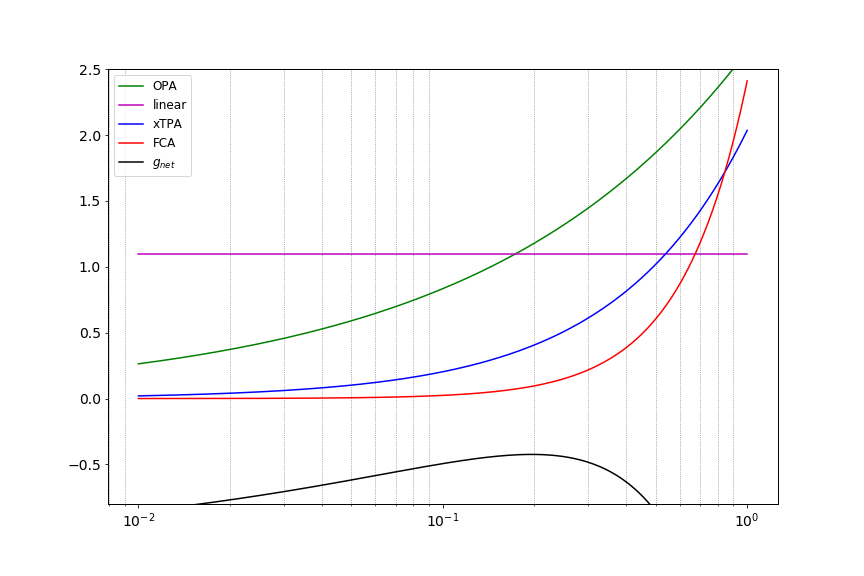

In [19]:
# plot net gain model for IMEC V2 fabricated devices
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.semilogx(P_p,OPA_term_dB,ls='-',color='g',label='OPA')
ax.semilogx([P_p.min().m,P_p.max().m],[linear_term_dB.m, linear_term_dB.m],ls='-',color='m',label='linear')
ax.semilogx(P_p,xTPA_term_dB,ls='-',color='b',label='xTPA')
ax.semilogx(P_p,FCA_term_dB,ls='-',color='r',label='FCA')
ax.semilogx(P_p,g_net_dB,ls='-',color='k',label='$g_{net}$')

ax.set_ylim([-.8,2.5])
ax.grid()
ax.legend()


# OPA+SHG data

## ds2

In [7]:
fpath_ds1_15 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T15_2018_12_12_21_51_00.hdf5'))
fpath_ds1_25 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T25_2018_12_12_23_23_25.hdf5'))
fpath_ds1_30 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T30_2018_12_13_03_15_30.hdf5'))
fpath_ds1_45 = path.normpath(path.join(default_data_dir,'OPO_data_ds1_V2_w800_g200_T45_2018_12_13_04_50_08.hdf5'))

fpath_ds2_15 = path.normpath(path.join(default_data_dir,'OPO_data_ds2_V2_w800_g200_T20_2018_12_14_20_46_57.hdf5'))
fpath_ds2_30 = path.normpath(path.join(default_data_dir,'OPO_data_ds2_V2_w800_g200_T30_2018_12_14_23_39_53.hdf5'))

fpath_ds3_g300_20 = path.normpath(path.join(default_data_dir,'OPO_data_ds3_V2_w800_g300_T20_2019_02_14_06_04_12.hdf5'))

fpath_ds3_g400_20 = path.normpath(path.join(default_data_dir,'OPO_data_ds3_V2_w800_g400_T20_2019_02_15_01_58_17.hdf5'))

fpath_ds3_WB1_CH2_g400_20 = path.normpath(path.join(default_data_dir,'OPO_data_ds3_V2_WB1_CH2_w800_g400_T20_2019_02_17_14_27_52.hdf5'))

from scipy import signal


n_skip_scope0 = 10
n_skip_scope2 = 10

with h5py.File(fpath_ds3_WB1_CH2_g400_20,'r') as f:
    λ = f['lm'][...] * u.nm
    t_scope0 = time_array(f['12_off/V_24_trans'])[::n_skip_scope0]
#    t_scope2 = time_array(f['12_on/V_12_ref'])[::n_skip_scope2]
#     T_24 = f['V_24_trans'][...] / signal.resample(f['V_24_ref'][...],f['V_24_trans'].attrs['length'])
#     T_12 = f['V_12_trans'][...] / signal.resample(f['V_12_ref'][...],f['V_12_trans'].attrs['length'])
#    T_24 = signal.resample(f['V_24_trans'][...],f['V_24_ref'].attrs['length']) / f['V_24_ref'][...]
#     T_12 = signal.resample(f['12_on/V_12_trans'][...],f['12_on/V_12_ref'].attrs['length']) / f['12_on/V_12_ref'][...]
#    T_24_12_on = f['12_on/V_24_trans'][::n_skip_scope0,:,:]
#    ref_24_12_on = f['12_on/V_24_ref'][::n_skip_scope2,:,:]
#    T_12 = f['12_on/V_12_trans'][::n_skip_scope0,:,:]
#    ref_12 = f['12_on/V_12_ref'][::n_skip_scope2,:,:]
    T_24_12_off = f['12_off/V_24_trans'][::n_skip_scope0,:,:]
    ref_24_12_off = f['12_off/V_24_ref'][::n_skip_scope2,:,:]
#     SHG_X = f['12_off/V_SHG_X'][:,:,:]
#     SHG_Y = f['12_off/V_SHG_Y'][:,:,:]
    
#T_24_12_on_norm = T_24_12_on / ref_24_12_on
#T_12_norm = T_12 / ref_12
T_24_12_off_norm = T_24_12_off / ref_24_12_off

<IPython.core.display.Javascript object>


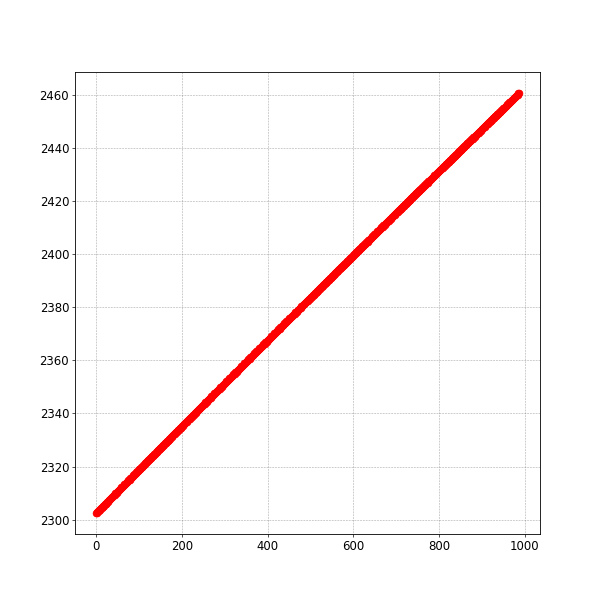

In [10]:
# %matplotlib inline
#plt.plot(np.sort(λ.flatten())[47:],'ro')

fig,ax = plt.subplots(figsize=(10,10))
sort_inds = np.argsort(λ.reshape((λ.size,)))
ax.plot(λ.ravel()[sort_inds][13:],'ro')



λ_sort = λ.ravel()[sort_inds]
#t_scope0 = λ_sort = λ.ravel()[sort_inds]
#T_24_12_on_sort = T_24_12_on.reshape((T_24_12_on.shape[0],λ.size))[:,sort_inds]
T_24_12_off_sort = T_24_12_off.reshape((T_24_12_off.shape[0],λ.size))[:,sort_inds]
#T_24_12_on_norm_sort = T_24_12_on_norm.reshape((T_24_12_on_norm.shape[0],λ.size))[:,sort_inds]
T_24_12_off_norm_sort = T_24_12_off_norm.reshape((T_24_12_off_norm.shape[0],λ.size))[:,sort_inds]
#T_12_sort = T_12.reshape((T_12.shape[0],λ.size))[:,sort_inds]
# SHG_X_sort = SHG_X.reshape((SHG_X.shape[0],λ.size))[:,sort_inds]
# SHG_Y_sort = SHG_Y.reshape((SHG_Y.shape[0],λ.size))[:,sort_inds]


<IPython.core.display.Javascript object>


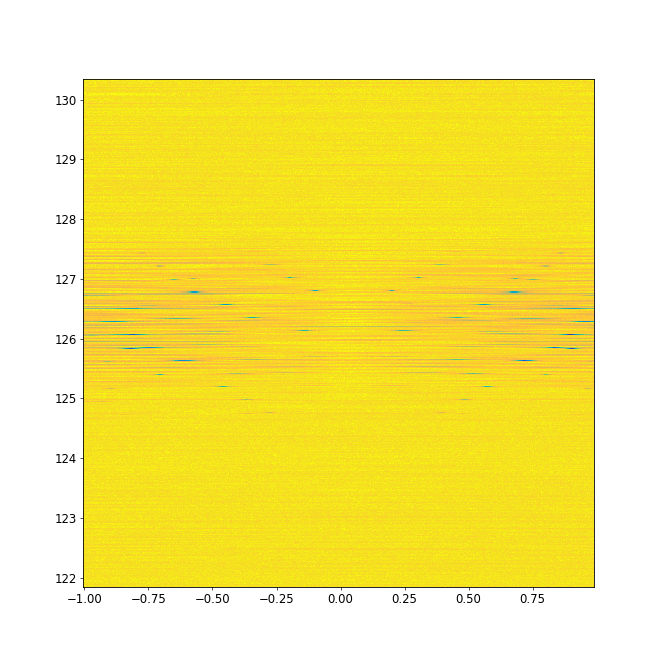

In [11]:
fig,ax = plt.subplots(1,1,figsize=(11,11))
#%matplotlib inline
z0 = T_24_12_off_sort/T_24_12_off_sort.max(axis=0)
#z1 = T_24_12_on_sort/T_24_12_on_sort.mean(axis=0)

#z0 = T_24_12_off_norm_sort
# z1 = T_24_12_on_norm_sort


t = t_scope0


λ_ind_min = 0
λ_ind_max = len(λ_sort)

λ_sort_filt = λ_sort[λ_ind_min:λ_ind_max]
f_s = λ_sort_filt.to(u.THz,'sp')
δf_s = np.diff(f_s.to(u.GHz))

ax.pcolormesh(t,f_s,z0[:,λ_ind_min:λ_ind_max].T)
#ax[1].pcolormesh(t,f_s,z1[:,λ_ind_min:λ_ind_max].T)




<IPython.core.display.Javascript object>


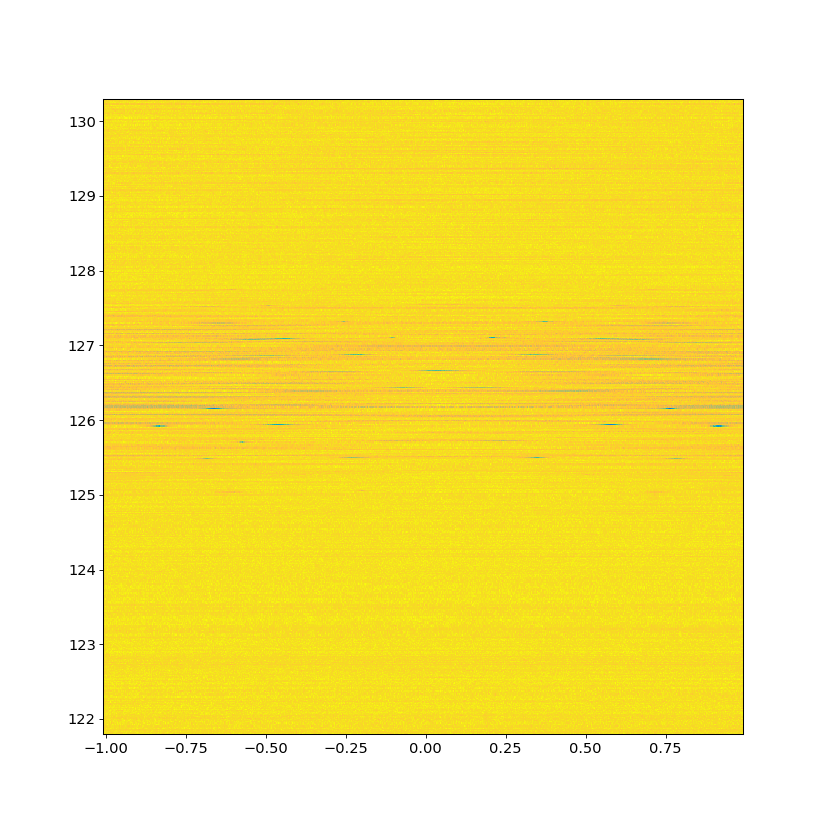

In [147]:
fig,ax = plt.subplots(1,1,figsize=(11,11))
#%matplotlib inline
z0 = T_24_12_off_sort/T_24_12_off_sort.max(axis=0)
z1 = T_24_12_on_sort/T_24_12_on_sort.mean(axis=0)

#z0 = T_24_12_off_norm_sort
# z1 = T_24_12_on_norm_sort


t = t_scope0


λ_ind_min = 0
λ_ind_max = len(λ_sort)

λ_sort_filt = λ_sort[λ_ind_min:λ_ind_max]
f_s = λ_sort_filt.to(u.THz,'sp')
δf_s = np.diff(f_s.to(u.GHz))

ax.pcolormesh(t,f_s,z0[:,λ_ind_min:λ_ind_max].T)
#ax[1].pcolormesh(t,f_s,z1[:,λ_ind_min:λ_ind_max].T)



In [ ]:
plt.plot(λ,ref_24_12_off_sort)

<IPython.core.display.Javascript object>


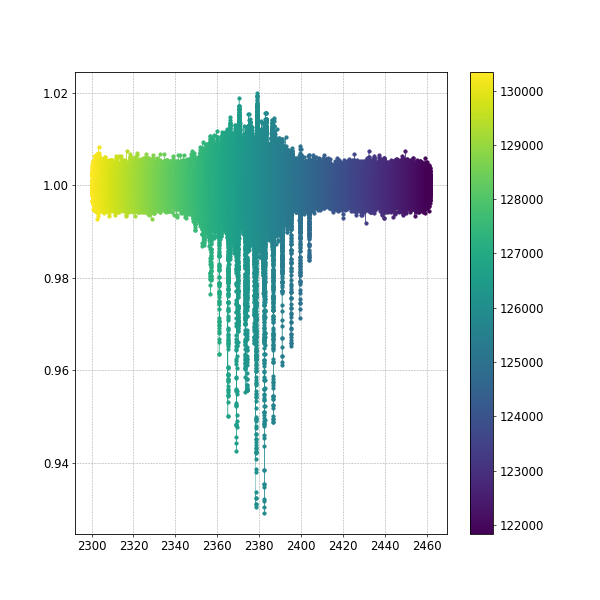

δf_δt: -47.9 gigahertz / second


In [12]:
%matplotlib notebook
fig,ax = plt.subplots(figsize=(10,10))

# ref_24_12_on_sort = ref_24_12_on.reshape((ref_24_12_on.shape[0],λ.size))[:,sort_inds]
# ref_24_12_off_sort = ref_24_12_on.reshape((ref_24_12_off.shape[0],λ.size))[:,sort_inds]
# ref_24_12_on_sort_filt = ref_24_12_on_sort[λ_ind_min:λ_ind_max]
# ref_24_12_off_sort_filt = ref_24_12_off_sort[λ_ind_min:λ_ind_max]

#z = ref_24_12_off_sort
#plt.pcolormesh(t_scope2,λ_sort[λ_ind_min:λ_ind_max],z[:,λ_ind_min:λ_ind_max].T)
#plt.colorbar()
#plt.plot(λ_sort_filt,ref_24_12_on_sort_filt,'r')
#plt.grid()

f_min = 121.0*u.THz
f_max = 132.5*u.THz

f_s = λ_sort_filt.to(u.THz,'sp')
δf_s = np.diff(f_s.to(u.GHz))
#plt.plot(f_s[:-1],δf_s)
δt = (0.514 - 0.368) * u.second
δf = -7 * u.GHz
δf_δt = (δf / δt).to(u.GHz/u.second)
Δf_ring = (δf_δt * (t_scope0.max() - t_scope0.min())/2.0).to(u.GHz)
printval(δf_δt)

cmap = cm.viridis #parula
f = λ_sort_filt.to(u.GHz,'sp') 
f_filt=f[(f<f_max)*(f>f_min)]
norm = Normalize(f_filt.min().m,f_filt.max().m)
sm = cm.ScalarMappable(norm, cmap)
sm.set_array([]) # You have to set a dummy-array for this to work...

t=t_scope0
t_middle = 0.0875 * u.second
t_min = t.min() + 0.1 * ( t_middle - t.min() )
t_max = t.min() + 0.9 * ( t_middle - t.min() )
t_filt_mask = (t>t_min)*(t<t_max)
t_filt = t[t_filt_mask] - t.min()
z = T_24_12_off_sort/T_24_12_off_sort.mean(axis=0)
z = z[t_filt_mask,λ_ind_min:λ_ind_max][:,(f<f_max)*(f>f_min)]
#ax.grid()

for find,ff in enumerate(f_filt):
    x_abs = (ff + t_filt * δf_δt).to(u.GHz)
    x_rel = x_abs - f_filt.to(u.GHz).min()
    y = z[:,find] #[t_scope2<t_scope2_middle]
    ax.plot(x_abs.to(u.nm,'sp'),y,'.-',lw=0.5,color=cmap(norm(ff.m)))
plt.colorbar(sm)

<IPython.core.display.Javascript object>


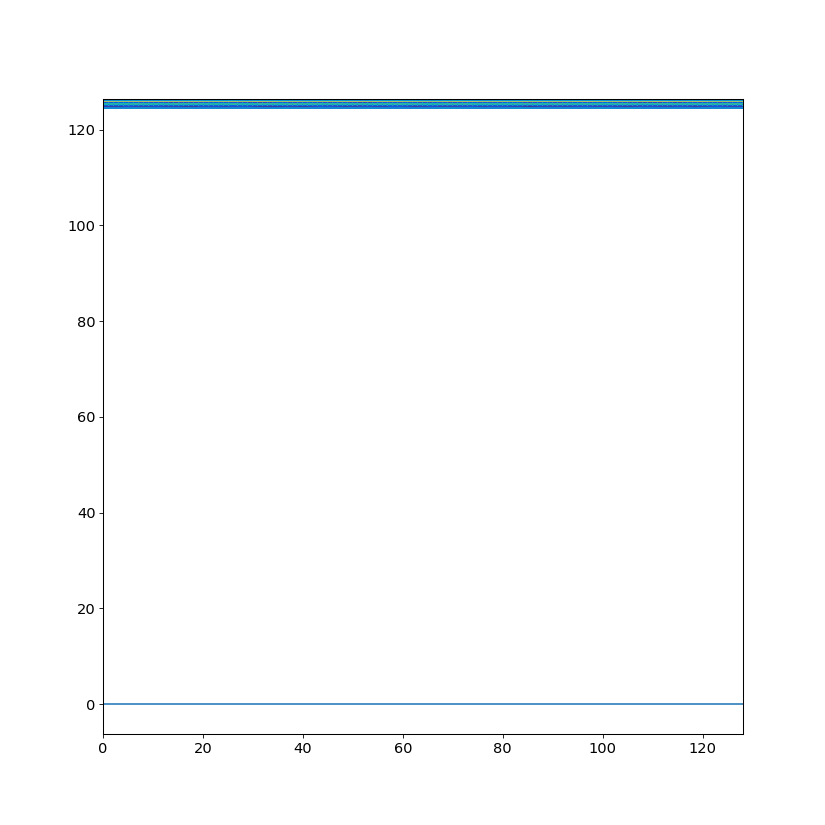

In [66]:
fig,ax = plt.subplots(figsize=(11,11))
#%matplotlib inline
z0 = SHG_X_sort
z1 = SHG_Y_sort
#z = T_24_12_on_norm_sort
#z1 = T_24_12_on_sort
#z0 = ref_24_12_on_sort
#z.shape:(400, 500) (n_skip = 25)

λ_ind_min = 11
λ_ind_max = 500

λ_sort_filt = λ_sort[λ_ind_min:λ_ind_max]
f_s = λ_sort_filt.to(u.THz,'sp')
δf_s = np.diff(f_s.to(u.GHz))

ax.plot(range(z0.shape[0]),f_s,z0[:,λ_ind_min:λ_ind_max].T)
#ax[1].pcolormesh(range(z1.shape[0]),f_s,z1[:,λ_ind_min:λ_ind_max].T)



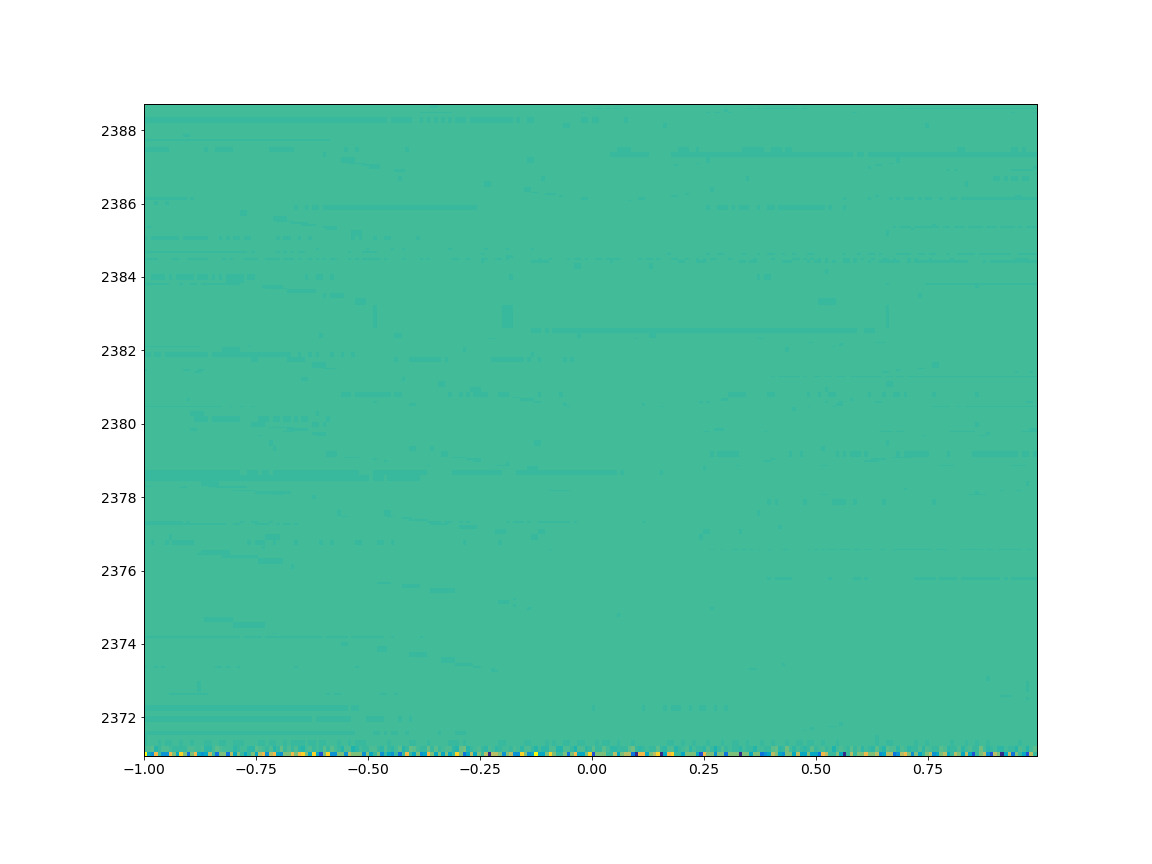

In [26]:
%matplotlib inline
z = T_12_sort/T_12_sort.mean(axis=0)
#z = T_24_12_on_sort
#z.shape:(400, 500) (n_skip = 25)

λ_ind_min = 12
λ_ind_max = 225

fig,ax = plt.subplots(1,1,figsize=(16,12))
plt.pcolormesh(t_scope2,λ_sort[λ_ind_min:λ_ind_max],z[:,λ_ind_min:λ_ind_max].T)

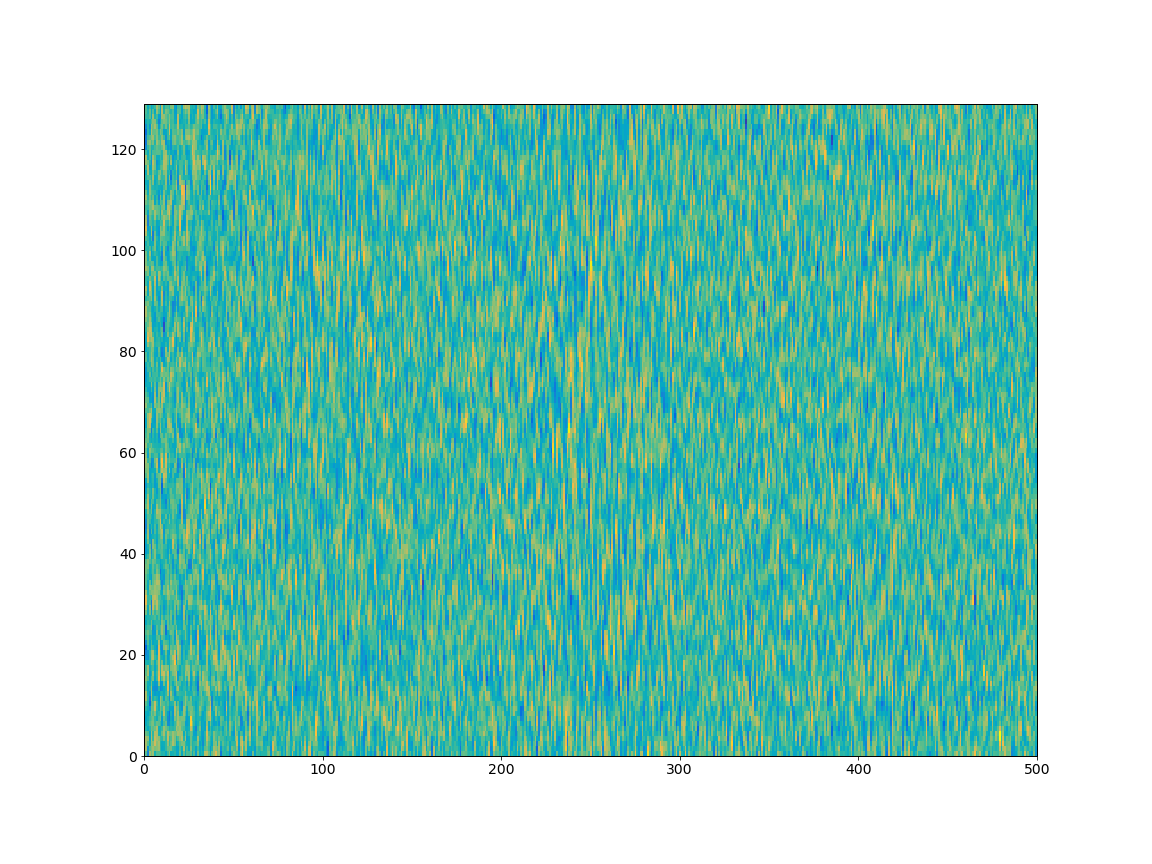

In [38]:
fig,ax = plt.subplots(1,1,figsize=(16,12))
z = SHG_X_sort -  SHG_X_sort.mean(axis=0).reshape((1,500))
plt.pcolormesh(z)

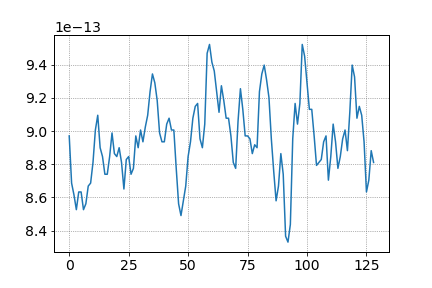

In [36]:
lind=100
plt.plot(SHG_X_sort[:,lind])

## Argos + IPG SFG data

In [7]:
default_data_dir = 'C:/Users/Lab/Google Drive/data/'

import glob
import numpy as np
from instrumental import instrument, Q_, u
from glob import glob
from os import path
import os, sys
import pickle
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
from matplotlib.colors import Normalize
from datetime import datetime
from time import sleep
from pathlib import Path
import h5py
import time

def load_SHG_V_wavelength_sweep(name='',data_dir=default_data_dir,verbose=False,set_dir=None,
                                metadata=False,exact_name=False):
    if set_dir:
        if verbose:
            print_statusline('Loading data from dir: ' + path.basename(path.normpath(set_dir)))
    else:
        file_list =  glob(path.normpath(data_dir)+path.normpath('/'+ 'SHG_V_wavelength_sweep_' + name + '*'))
        set_dir = path.normpath(max(file_list,key=path.getctime))
        if verbose:
            print_statusline('Loading data from dir: ' + path.basename(set_dir))
    sweep_file_list =  glob(path.normpath(set_dir)+path.normpath('/'+ 'sweep_data' + '*'))
    latest_sweep_file = path.normpath(max(sweep_file_list,key=path.getctime))
    with open(latest_sweep_file, "rb" ) as f:
        ds = pickle.load(f)
    for Vind,VV in enumerate(ds['V']):
        V_dir = path.normpath(path.join(set_dir,f'{VV.m:3.2f}V'))
        V_ds = load_shg_wavelength_sweep(fpath=path.join(V_dir,f'{VV.m:3.2f}V.npz'))
        if Vind==0:
            n_lm = V_ds['lm_meas'].shape[0]
            n_pts_per_setpoint = V_ds['lm_meas'].shape[1]
            lm_meas = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.nm
            V_R = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.volt
            theta = np.zeros((n_lm,n_pts_per_setpoint,len(ds['V']))) * u.degree
        lm_meas[:,:,Vind] = V_ds['lm_meas']
        V_R[:,:,Vind] = V_ds['V_R']
        theta[:,:,Vind] = V_ds['theta']
    ds['lm_meas'] = lm_meas
    ds['V_R'] = V_R
    ds['theta'] = theta
    return ds

def load_shg_wavelength_sweep(name='',data_dir=default_data_dir,verbose=False,
                     fpath=None,metadata=False,exact_name=False):
    if fpath:
        if verbose:
            print_statusline('Loading data from file: ' + path.basename(path.normpath(fpath)))
        data_npz = np.load(Path(fpath))
    else:
        file_list =  glob(path.normpath(data_dir)+path.normpath('/'+ 'SHG_wavelength_sweep_' + name + '*'))
        latest_file = max(file_list,key=path.getctime)
        if verbose:
            print_statusline('Loading ' + name +' data from file: ' + path.basename(path.normpath(latest_file)))
        data_npz = np.load(latest_file)
    lm_meas = data_npz['lm_meas'] * u.nm
    V_R = data_npz['V_R'] * u.volt
    theta = data_npz['theta'] * u.degree
    try:
        V_P_24_trans = data_npz['V_P_24_trans'] * u.volt
        V_P_24_ref = data_npz['V_P_24_ref'] * u.volt
        ds = {'lm_meas':lm_meas,
                'V_P_24_trans':V_P_24_trans,
                'V_P_24_ref':V_P_24_ref,
                'V_R':V_R,
                'theta':theta}
    except:
        ds = {'lm_meas':lm_meas,
                'V_R':V_R,
                'theta':theta}
    return ds


In [3]:
name = 'V2_WB2_CH3_top_right_SFG_20C_retry5'

ds = load_SHG_V_wavelength_sweep(name=name)

In [4]:
ds.keys()

dict_keys(['V', 'lm_meas', 'V_R', 'theta'])

<IPython.core.display.Javascript object>


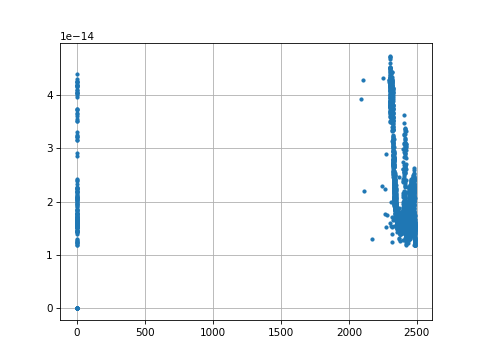

In [5]:
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
# ax.set_xlim([2250,2450])
plt.show()

<IPython.core.display.Javascript object>


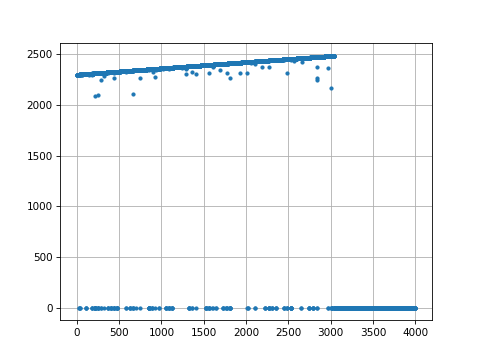

In [6]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
ax.plot(ds['lm_meas'].squeeze().m,'.')
ax = plt.gca()
ax.grid()
#ax.set_xlim([2300,2475])
plt.show()

<IPython.core.display.Javascript object>


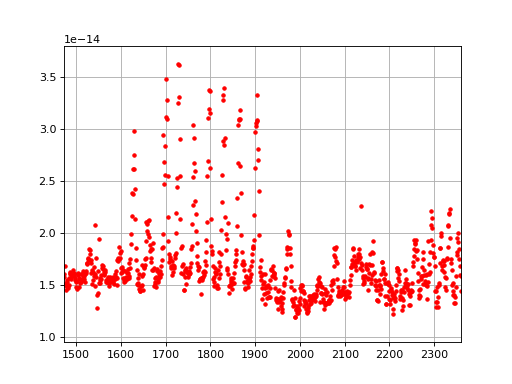

In [58]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
ax.plot(ds['V_R'].squeeze().m,'r.')
ax = plt.gca()
ax.grid()
#ax.set_xlim([2300,2475])
plt.show()

<IPython.core.display.Javascript object>


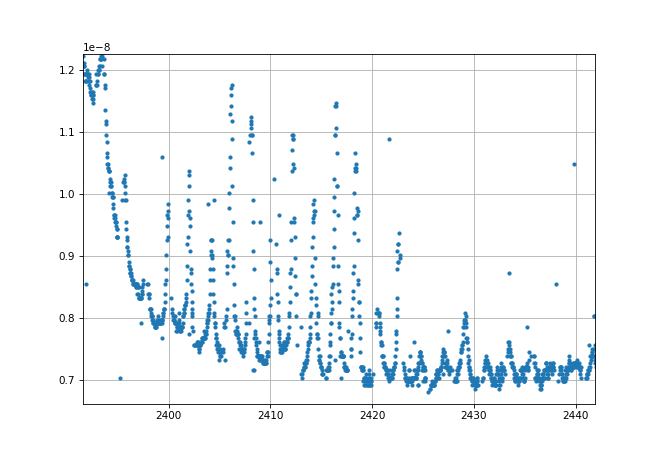

In [7]:
name0 = 'V2_WB2_CH3_top_right_SFG_20C_retry6'

ds = load_SHG_V_wavelength_sweep(name=name0)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
# ax.set_xlim([2250,2450])
plt.show()

<IPython.core.display.Javascript object>


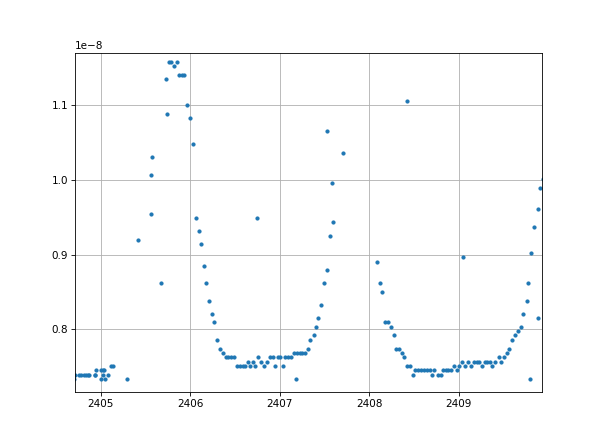

In [82]:
name1 = 'V2_WB2_CH3_top_right_SFG_35C_retry7'

ds = load_SHG_V_wavelength_sweep(name=name1)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
# ax.set_xlim([2250,2450])
plt.show()



<IPython.core.display.Javascript object>


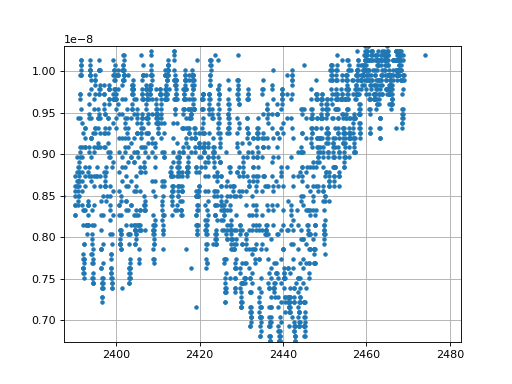

In [80]:
name2 = 'V2_WB2_CH3_top_right_SFG_45C_retry7'

ds = load_SHG_V_wavelength_sweep(name=name2)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
# ax.set_xlim([2250,2450])
plt.show()



<IPython.core.display.Javascript object>


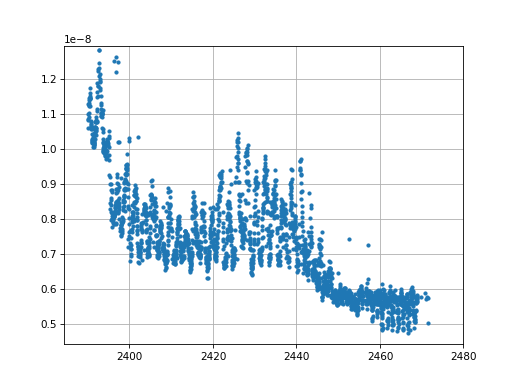

In [39]:
name3 = 'V2_WB2_CH3_top_right_SFG_20C_retry9'

ds = load_SHG_V_wavelength_sweep(name=name3)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
# ax.set_xlim([2250,2450])
plt.show()


<IPython.core.display.Javascript object>


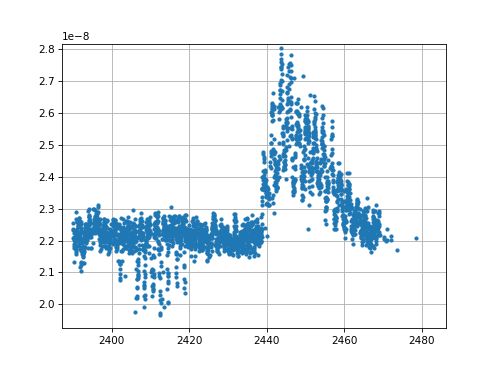

In [40]:
name4 = 'V2_WB2_CH3_top_right_SFG_20C_retry10_2019_02_01'

ds = load_SHG_V_wavelength_sweep(name=name4)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
#ax.set_xlim([2000,2400])
plt.show()


<IPython.core.display.Javascript object>


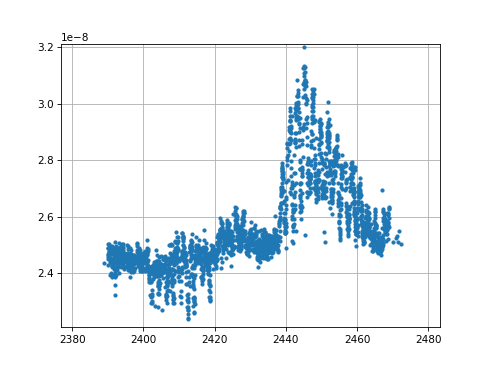

In [41]:
name3 = 'V2_WB2_CH3_top_right_SFG_20C_retry12_2019_02_02_14_44_40'

ds = load_SHG_V_wavelength_sweep(name=name3)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
# ax.set_xlim([2250,2450])
plt.show()


<IPython.core.display.Javascript object>


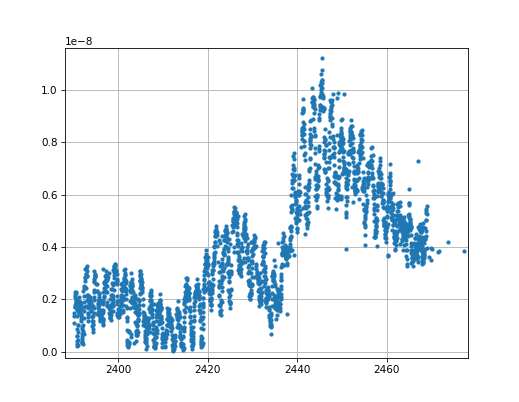

In [36]:
#argos off here
name4 = 'V2_WB2_CH3_top_right_SFG_20C_retry11'

ds = load_SHG_V_wavelength_sweep(name=name4)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
#ax.set_xlim([2000,2400])
plt.show()


<IPython.core.display.Javascript object>


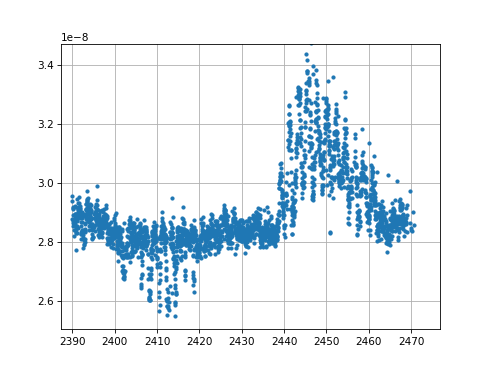

In [37]:
name4 = 'V2_WB2_CH3_top_right_SFG_20C_retry12_2019_02_04_09_35_44'

ds = load_SHG_V_wavelength_sweep(name=name4)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
#ax.set_xlim([2000,2400])
plt.show()


<IPython.core.display.Javascript object>


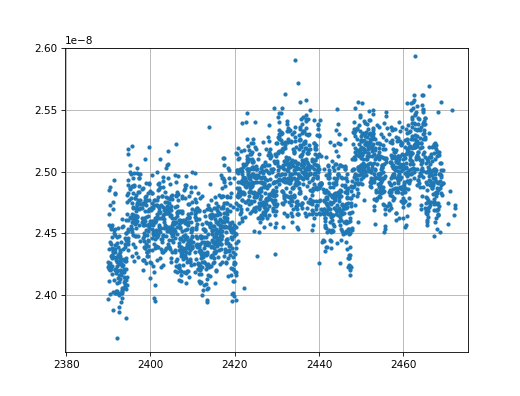

In [38]:
# ipg shut
name4 = 'V2_WB2_CH3_top_right_SFG_20C_retry13'

ds = load_SHG_V_wavelength_sweep(name=name4)
#ds.keys()
%matplotlib notebook
plt.plot(ds['lm_meas'].squeeze(),ds['V_R'].squeeze(),'.')
ax = plt.gca()
ax.grid()
#ax.set_xlim([2000,2400])
plt.show()


In [134]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))